In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
notebook = "syn2"

In [ ]:
import numpy as np
import pandas as pd

np.random.seed(42)
n = 500  # number of samples
p = 5    # number of features

# Generate Gaussian features
X = np.random.normal(0, 1, size=(n, p))

# True function: additive, no interactions
f = 2 * X[:, 0] - 1.5 * X[:, 1] + 0.5 * X[:, 2]

# Gaussian noise
sigma = 0.1 # Small noise
y = f + np.random.normal(0, sigma, size=n)

In [4]:
ndpost = 10000
nskip = 0
n_trees = 100

In [5]:
from experiment_init import run_parallel_experiments

# Run 5 parallel experiments
results = run_parallel_experiments(X, y, ndpost, nskip, n_trees, notebook, 
                                   n_runs=5, n_jobs=-2, store_preds=True, 
                                   n_test_points=100, # Store all test points if not specified
                                   n_chains=4)

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done   2 out of   5 | elapsed: 56.2min remaining: 84.4min
[Parallel(n_jobs=-2)]: Done   3 out of   5 | elapsed: 56.4min remaining: 37.6min
[Parallel(n_jobs=-2)]: Done   5 out of   5 | elapsed: 56.8min finished


In [6]:
experiment_results = np.load(f'store/{notebook}.npz', allow_pickle=True)

default_data = experiment_results['default'].item()
mtmh_data = experiment_results['mtmh'].item()
metadata = experiment_results['metadata'].item()

n_runs = metadata['n_runs']

# Gelman-Rubin Rhat

INFO:arviz.preview:arviz_base not installed
INFO:arviz.preview:arviz_stats not installed
INFO:arviz.preview:arviz_plots not installed


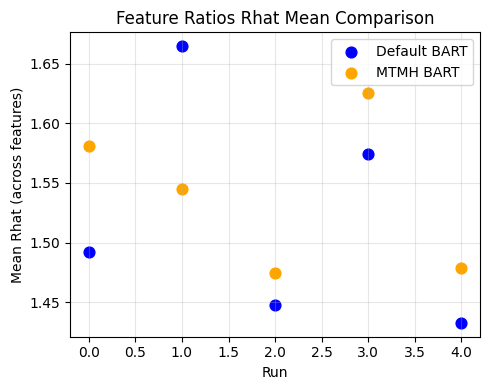

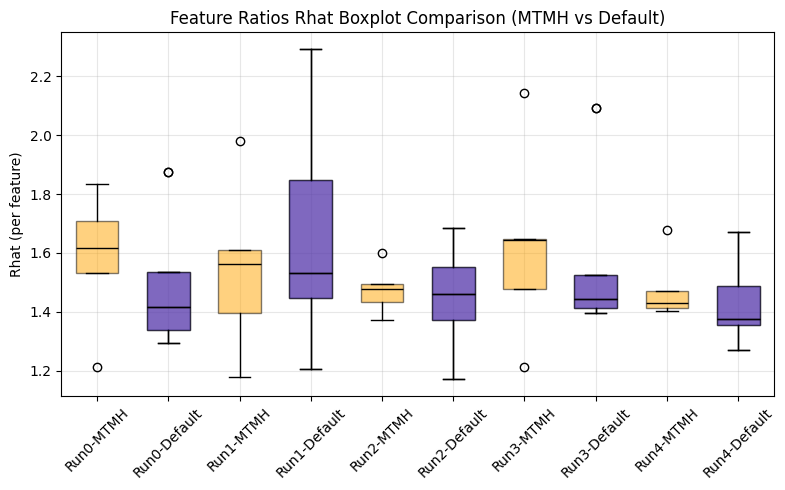

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import arviz as az

default_ratios = experiment_results['default'].item()['feature_ratios']
mtmh_ratios = experiment_results['mtmh'].item()['feature_ratios']
n_runs, n_chains, n_iter, n_features = default_ratios.shape

def rhat_stats_per_run_ratios(ratios):
    mean_rhat = []
    rhat_list = []
    for run_id in range(n_runs):
        run_ratios = ratios[run_id]  # [n_chains, n_iter, n_features]
        rhat_per_feat = []
        for feat_id in range(n_features):
            chains_feat = run_ratios[:, :, feat_id]  # [n_chains, n_iter]
            rhat = az.rhat(chains_feat)
            rhat_per_feat.append(rhat)
        mean_rhat.append(np.mean(rhat_per_feat))
        rhat_list.append(rhat_per_feat)
    return np.array(mean_rhat), rhat_list  # mean_rhat: [n_runs], rhat_list: [n_runs, n_features]

default_mean_rhat, default_rhat_list = rhat_stats_per_run_ratios(default_ratios)
mtmh_mean_rhat, mtmh_rhat_list = rhat_stats_per_run_ratios(mtmh_ratios)

# Mean Rhat comparison plot
plt.figure(figsize=(5,4))
plt.scatter(np.arange(n_runs), default_mean_rhat, label='Default BART', s=60, color='blue')
plt.scatter(np.arange(n_runs), mtmh_mean_rhat, label='MTMH BART', s=60, color='orange')
plt.xlabel('Run')
plt.ylabel('Mean Rhat (across features)')
plt.title('Feature Ratios Rhat Mean Comparison')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Boxplot comparison
plt.figure(figsize=(8,5))
positions = []
labels = []
box_data = []
for run_id in range(n_runs):
    box_data.append(mtmh_rhat_list[run_id])
    positions.append(run_id*2)
    labels.append(f'Run{run_id}-MTMH')
    box_data.append(default_rhat_list[run_id])
    positions.append(run_id*2+1)
    labels.append(f'Run{run_id}-Default')

plt.boxplot(box_data, positions=positions, widths=0.6, patch_artist=True,
            boxprops=dict(facecolor='orange', alpha=0.5), medianprops=dict(color='black'))
for i in range(n_runs):
    plt.boxplot([box_data[i*2+1]], positions=[positions[i*2+1]], widths=0.6, patch_artist=True,
                boxprops=dict(facecolor='blue', alpha=0.5), medianprops=dict(color='black'))

plt.xticks(positions, labels, rotation=45)
plt.ylabel('Rhat (per feature)')
plt.title('Feature Ratios Rhat Boxplot Comparison (MTMH vs Default)')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

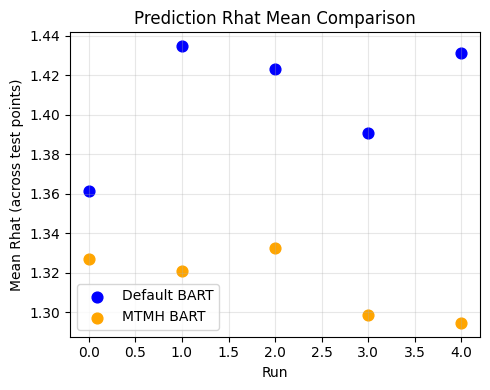

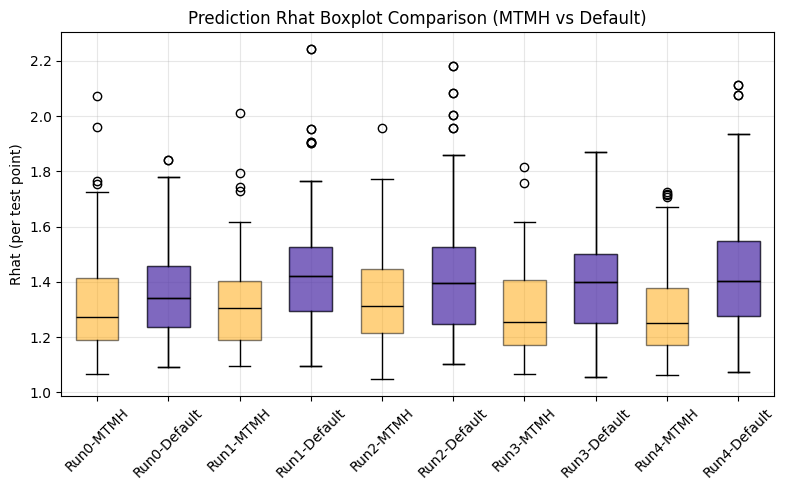

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import arviz as az

default_preds = experiment_results['default'].item()['preds']
mtmh_preds = experiment_results['mtmh'].item()['preds']
n_runs, n_chains, n_test_points, n_iter = default_preds.shape

def rhat_stats_per_run(preds):
    mean_rhat = []
    rhat_list = []
    for run_id in range(n_runs):
        run_preds = preds[run_id]  # [n_chains, n_test_points, n_iter]
        rhat_per_point = []
        for pt_id in range(n_test_points):
            chains_pred = run_preds[:, pt_id, :]  # [n_chains, n_iter]
            rhat = az.rhat(chains_pred)
            rhat_per_point.append(rhat)
        mean_rhat.append(np.mean(rhat_per_point))
        rhat_list.append(rhat_per_point)
    return np.array(mean_rhat), rhat_list  # mean_rhat: [n_runs], rhat_list: [n_runs, n_test_points]

default_mean_rhat, default_rhat_list = rhat_stats_per_run(default_preds)
mtmh_mean_rhat, mtmh_rhat_list = rhat_stats_per_run(mtmh_preds)

# Mean Rhat comparison plot
plt.figure(figsize=(5,4))
plt.scatter(np.arange(n_runs), default_mean_rhat, label='Default BART', s=60, color='blue')
plt.scatter(np.arange(n_runs), mtmh_mean_rhat, label='MTMH BART', s=60, color='orange')
plt.xlabel('Run')
plt.ylabel('Mean Rhat (across test points)')
plt.title('Prediction Rhat Mean Comparison')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Boxplot comparison
plt.figure(figsize=(8,5))
positions = []
labels = []
box_data = []
for run_id in range(n_runs):
    box_data.append(mtmh_rhat_list[run_id])
    positions.append(run_id*2)
    labels.append(f'Run{run_id}-MTMH')
    box_data.append(default_rhat_list[run_id])
    positions.append(run_id*2+1)
    labels.append(f'Run{run_id}-Default')

plt.boxplot(box_data, positions=positions, widths=0.6, patch_artist=True,
            boxprops=dict(facecolor='orange', alpha=0.5), medianprops=dict(color='black'))
for i in range(n_runs):
    plt.boxplot([box_data[i*2+1]], positions=[positions[i*2+1]], widths=0.6, patch_artist=True,
                boxprops=dict(facecolor='blue', alpha=0.5), medianprops=dict(color='black'))

plt.xticks(positions, labels, rotation=45)
plt.ylabel('Rhat (per test point)')
plt.title('Prediction Rhat Boxplot Comparison (MTMH vs Default)')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

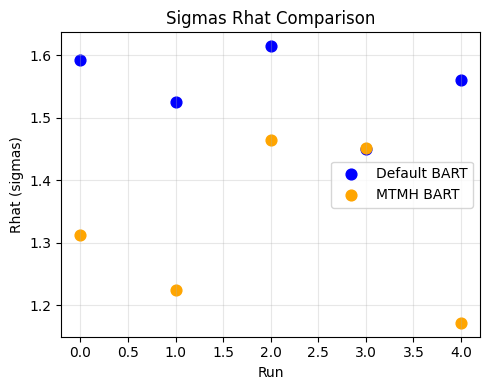

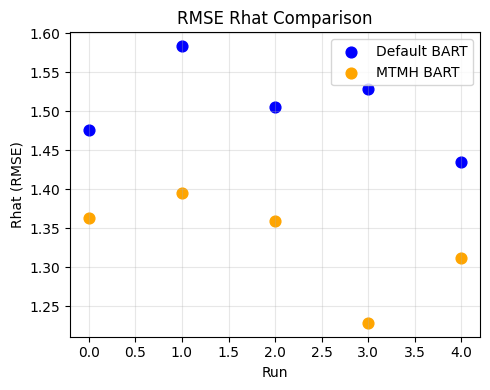

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import arviz as az

# --- Sigmas Rhat ---
default_sigmas = experiment_results['default'].item()['sigmas']
mtmh_sigmas = experiment_results['mtmh'].item()['sigmas']
n_runs = experiment_results['metadata'].item()['n_runs']

def rhat_per_run_1d(arr):
    # arr: [n_runs, n_chains, n_iter]
    rhat = []
    for run_id in range(n_runs):
        chains = arr[run_id]  # [n_chains, n_iter]
        chains = np.squeeze(chains)
        rhat_value = az.rhat(chains)
        rhat.append(rhat_value)
    return np.array(rhat)

default_sigmas_rhat = rhat_per_run_1d(default_sigmas)
mtmh_sigmas_rhat = rhat_per_run_1d(mtmh_sigmas)

plt.figure(figsize=(5,4))
plt.scatter(np.arange(n_runs), default_sigmas_rhat, label='Default BART', s=60, color='blue')
plt.scatter(np.arange(n_runs), mtmh_sigmas_rhat, label='MTMH BART', s=60, color='orange')
plt.xlabel('Run')
plt.ylabel('Rhat (sigmas)')
plt.title('Sigmas Rhat Comparison')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# --- RMSE Rhat ---
default_rmses = experiment_results['default'].item()['rmses']
mtmh_rmses = experiment_results['mtmh'].item()['rmses']

default_rmses_rhat = rhat_per_run_1d(default_rmses)
mtmh_rmses_rhat = rhat_per_run_1d(mtmh_rmses)

plt.figure(figsize=(5,4))
plt.scatter(np.arange(n_runs), default_rmses_rhat, label='Default BART', s=60, color='blue')
plt.scatter(np.arange(n_runs), mtmh_rmses_rhat, label='MTMH BART', s=60, color='orange')
plt.xlabel('Run')
plt.ylabel('Rhat (RMSE)')
plt.title('RMSE Rhat Comparison')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [10]:
default_data = experiment_results['default'].item()

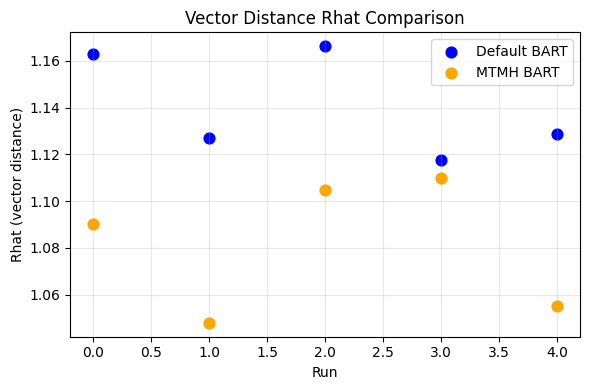

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import arviz as az

default_data = experiment_results['default'].item()
mtmh_data = experiment_results['mtmh'].item()
metadata = experiment_results['metadata'].item()
n_runs = metadata['n_runs']

default_vector = default_data['vector_distances']  # shape: [n_runs, n_chains, n_iter]
mtmh_vector = mtmh_data['vector_distances']
# default_subspace = default_data['subspace_distances']
# mtmh_subspace = mtmh_data['subspace_distances']

default_vector_rhat = rhat_per_run_1d(default_vector)
mtmh_vector_rhat = rhat_per_run_1d(mtmh_vector)
# default_subspace_rhat = rhat_per_run_1d(default_subspace)
# mtmh_subspace_rhat = rhat_per_run_1d(mtmh_subspace)

plt.figure(figsize=(6,4))
plt.scatter(np.arange(n_runs), default_vector_rhat, label='Default BART', s=60, color='blue')
plt.scatter(np.arange(n_runs), mtmh_vector_rhat, label='MTMH BART', s=60, color='orange')
plt.xlabel('Run')
plt.ylabel('Rhat (vector distance)')
plt.title('Vector Distance Rhat Comparison')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# plt.figure(figsize=(6,4))
# plt.scatter(np.arange(n_runs), default_subspace_rhat, label='Default BART', s=60, color='blue')
# plt.scatter(np.arange(n_runs), mtmh_subspace_rhat, label='MTMH BART', s=60, color='orange')
# plt.xlabel('Run')
# plt.ylabel('Rhat (subspace distance)')
# plt.title('Subspace Distance Rhat Comparison')
# plt.legend()
# plt.grid(alpha=0.3)
# plt.tight_layout()
# plt.show()

# Trace Plots Analysis
## Feature Selection Ratios

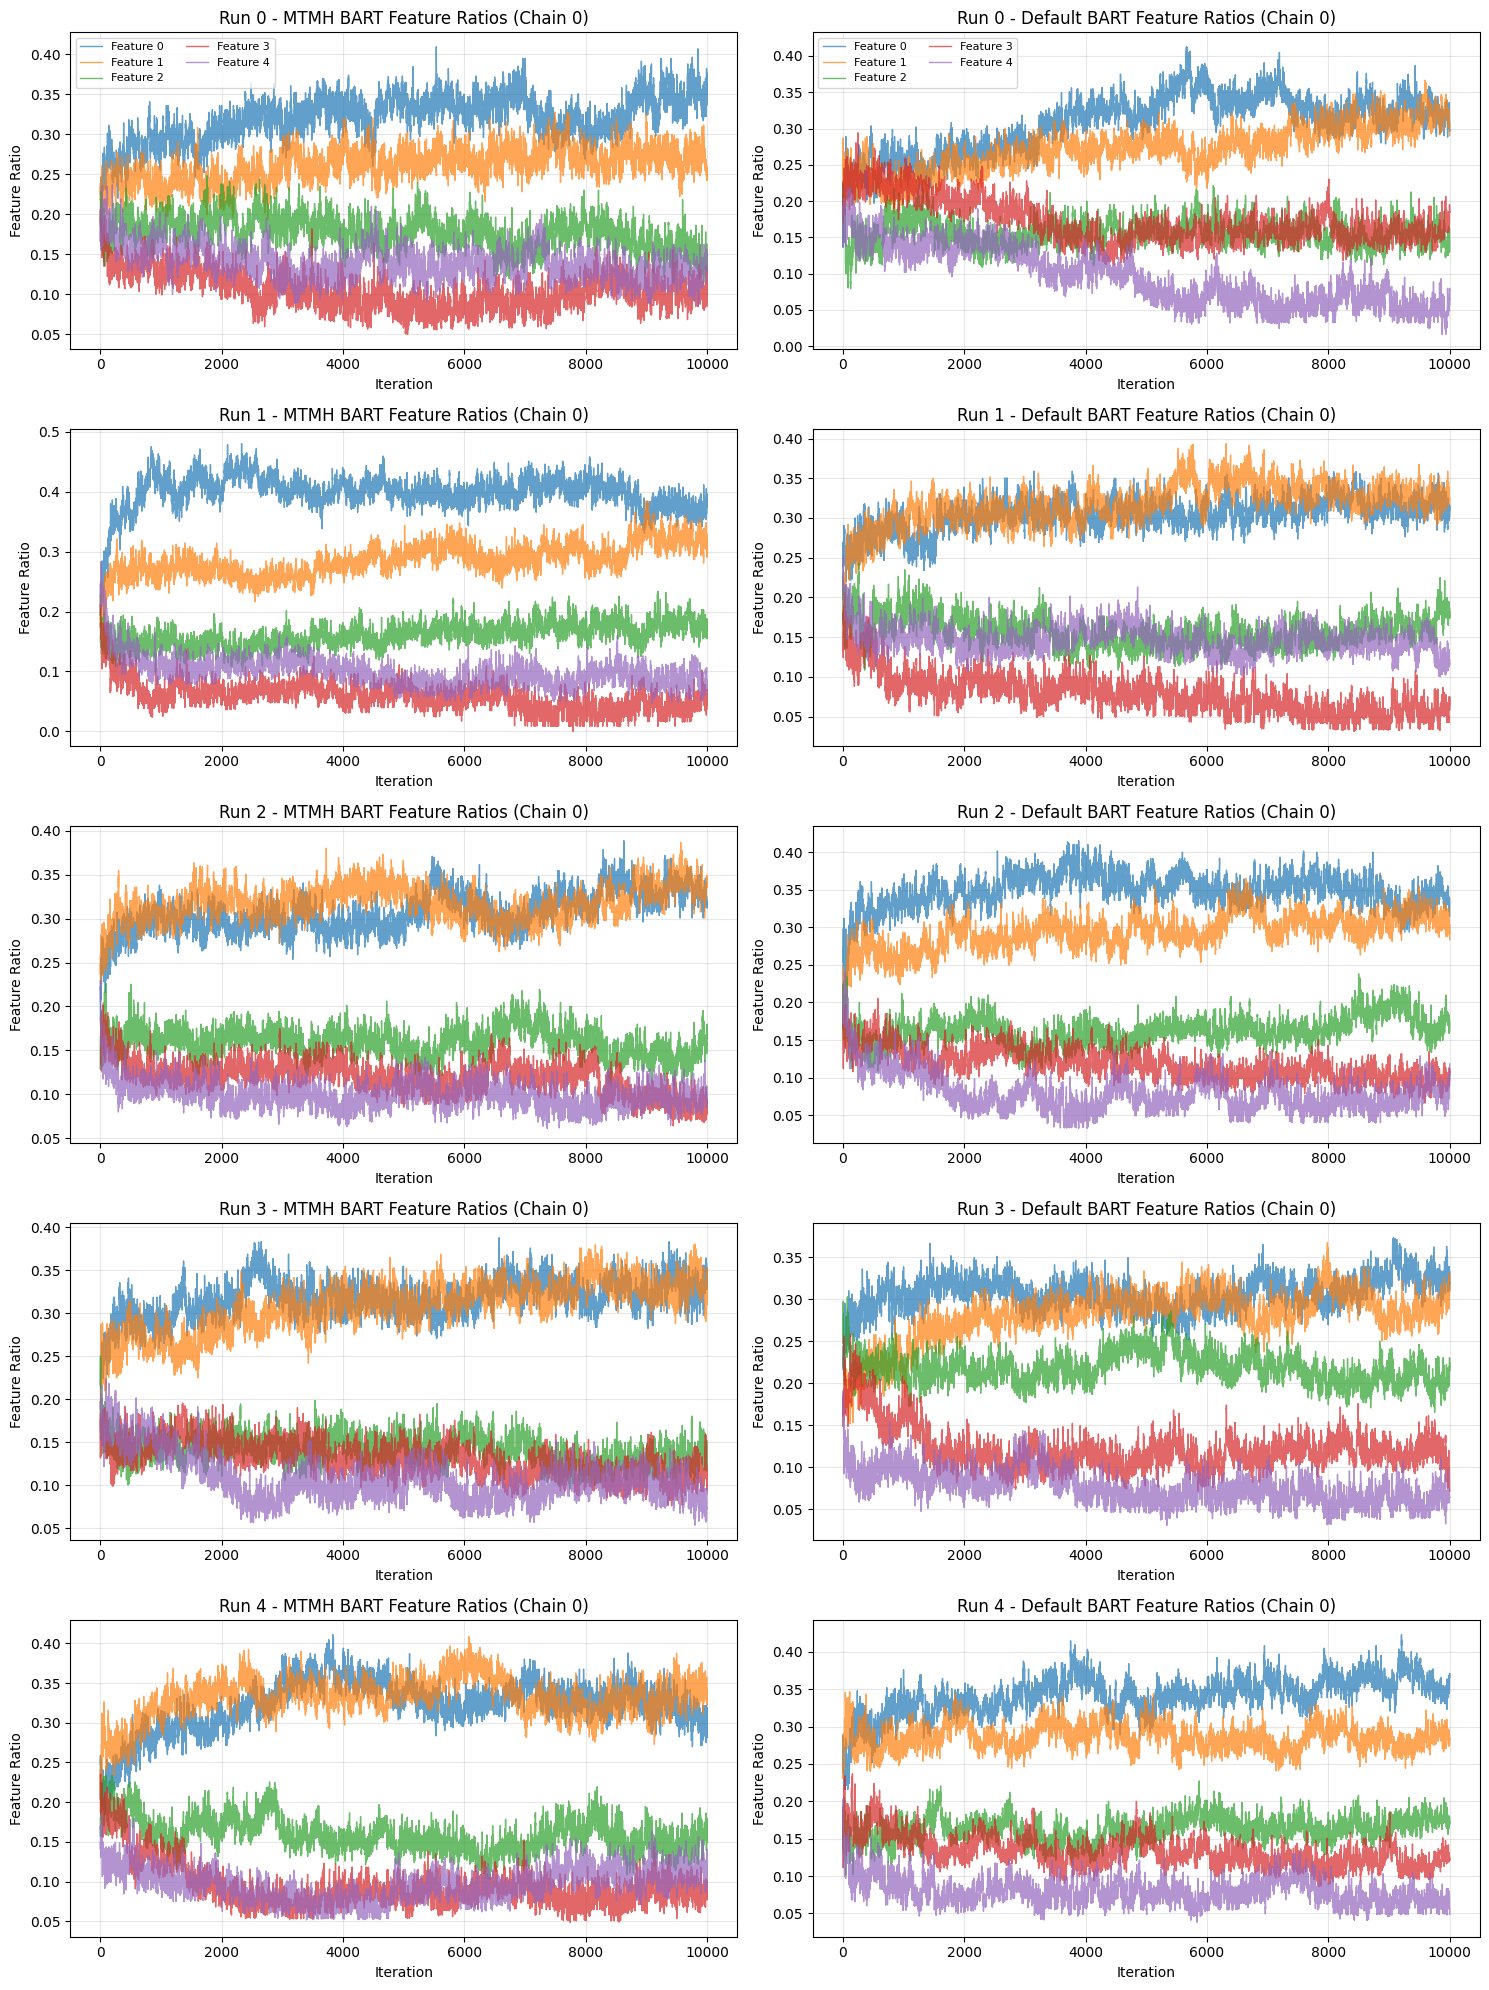

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Extract feature_ratios data for visualization
n_runs = experiment_results['metadata'].item()['n_runs']
default_ratios = experiment_results['default'].item()['feature_ratios']  # shape: [n_runs, n_chains, n_iter, n_features]
mtmh_ratios = experiment_results['mtmh'].item()['feature_ratios']

n_chains = default_ratios.shape[1]
n_iter = default_ratios.shape[2]
n_features = default_ratios.shape[3]

fig, axes = plt.subplots(n_runs, 2, figsize=(15, 4 * n_runs))
if n_runs == 1:
    axes = axes.reshape(1, -1)

for run_id in range(n_runs):
    # Extract the first chain's feature ratios for this run
    default_chain_ratios = default_ratios[run_id, 0, :, :]  # shape: [n_iter, n_features]
    mtmh_chain_ratios = mtmh_ratios[run_id, 0, :, :]        # shape: [n_iter, n_features]

    # Left: MTMH BART
    for feat_id in range(n_features):
        axes[run_id, 0].plot(mtmh_chain_ratios[:, feat_id], label=f'Feature {feat_id}' if run_id == 0 else None, alpha=0.7, linewidth=1)
    axes[run_id, 0].set_title(f'Run {run_id} - MTMH BART Feature Ratios (Chain 0)')
    axes[run_id, 0].set_xlabel('Iteration')
    axes[run_id, 0].set_ylabel('Feature Ratio')
    if run_id == 0:
        axes[run_id, 0].legend(ncol=2, fontsize=8)
    axes[run_id, 0].grid(True, alpha=0.3)

    # Right: Default BART
    for feat_id in range(n_features):
        axes[run_id, 1].plot(default_chain_ratios[:, feat_id], label=f'Feature {feat_id}' if run_id == 0 else None, alpha=0.7, linewidth=1)
    axes[run_id, 1].set_title(f'Run {run_id} - Default BART Feature Ratios (Chain 0)')
    axes[run_id, 1].set_xlabel('Iteration')
    axes[run_id, 1].set_ylabel('Feature Ratio')
    if run_id == 0:
        axes[run_id, 1].legend(ncol=2, fontsize=8)
    axes[run_id, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Tree Depth / #Leaves

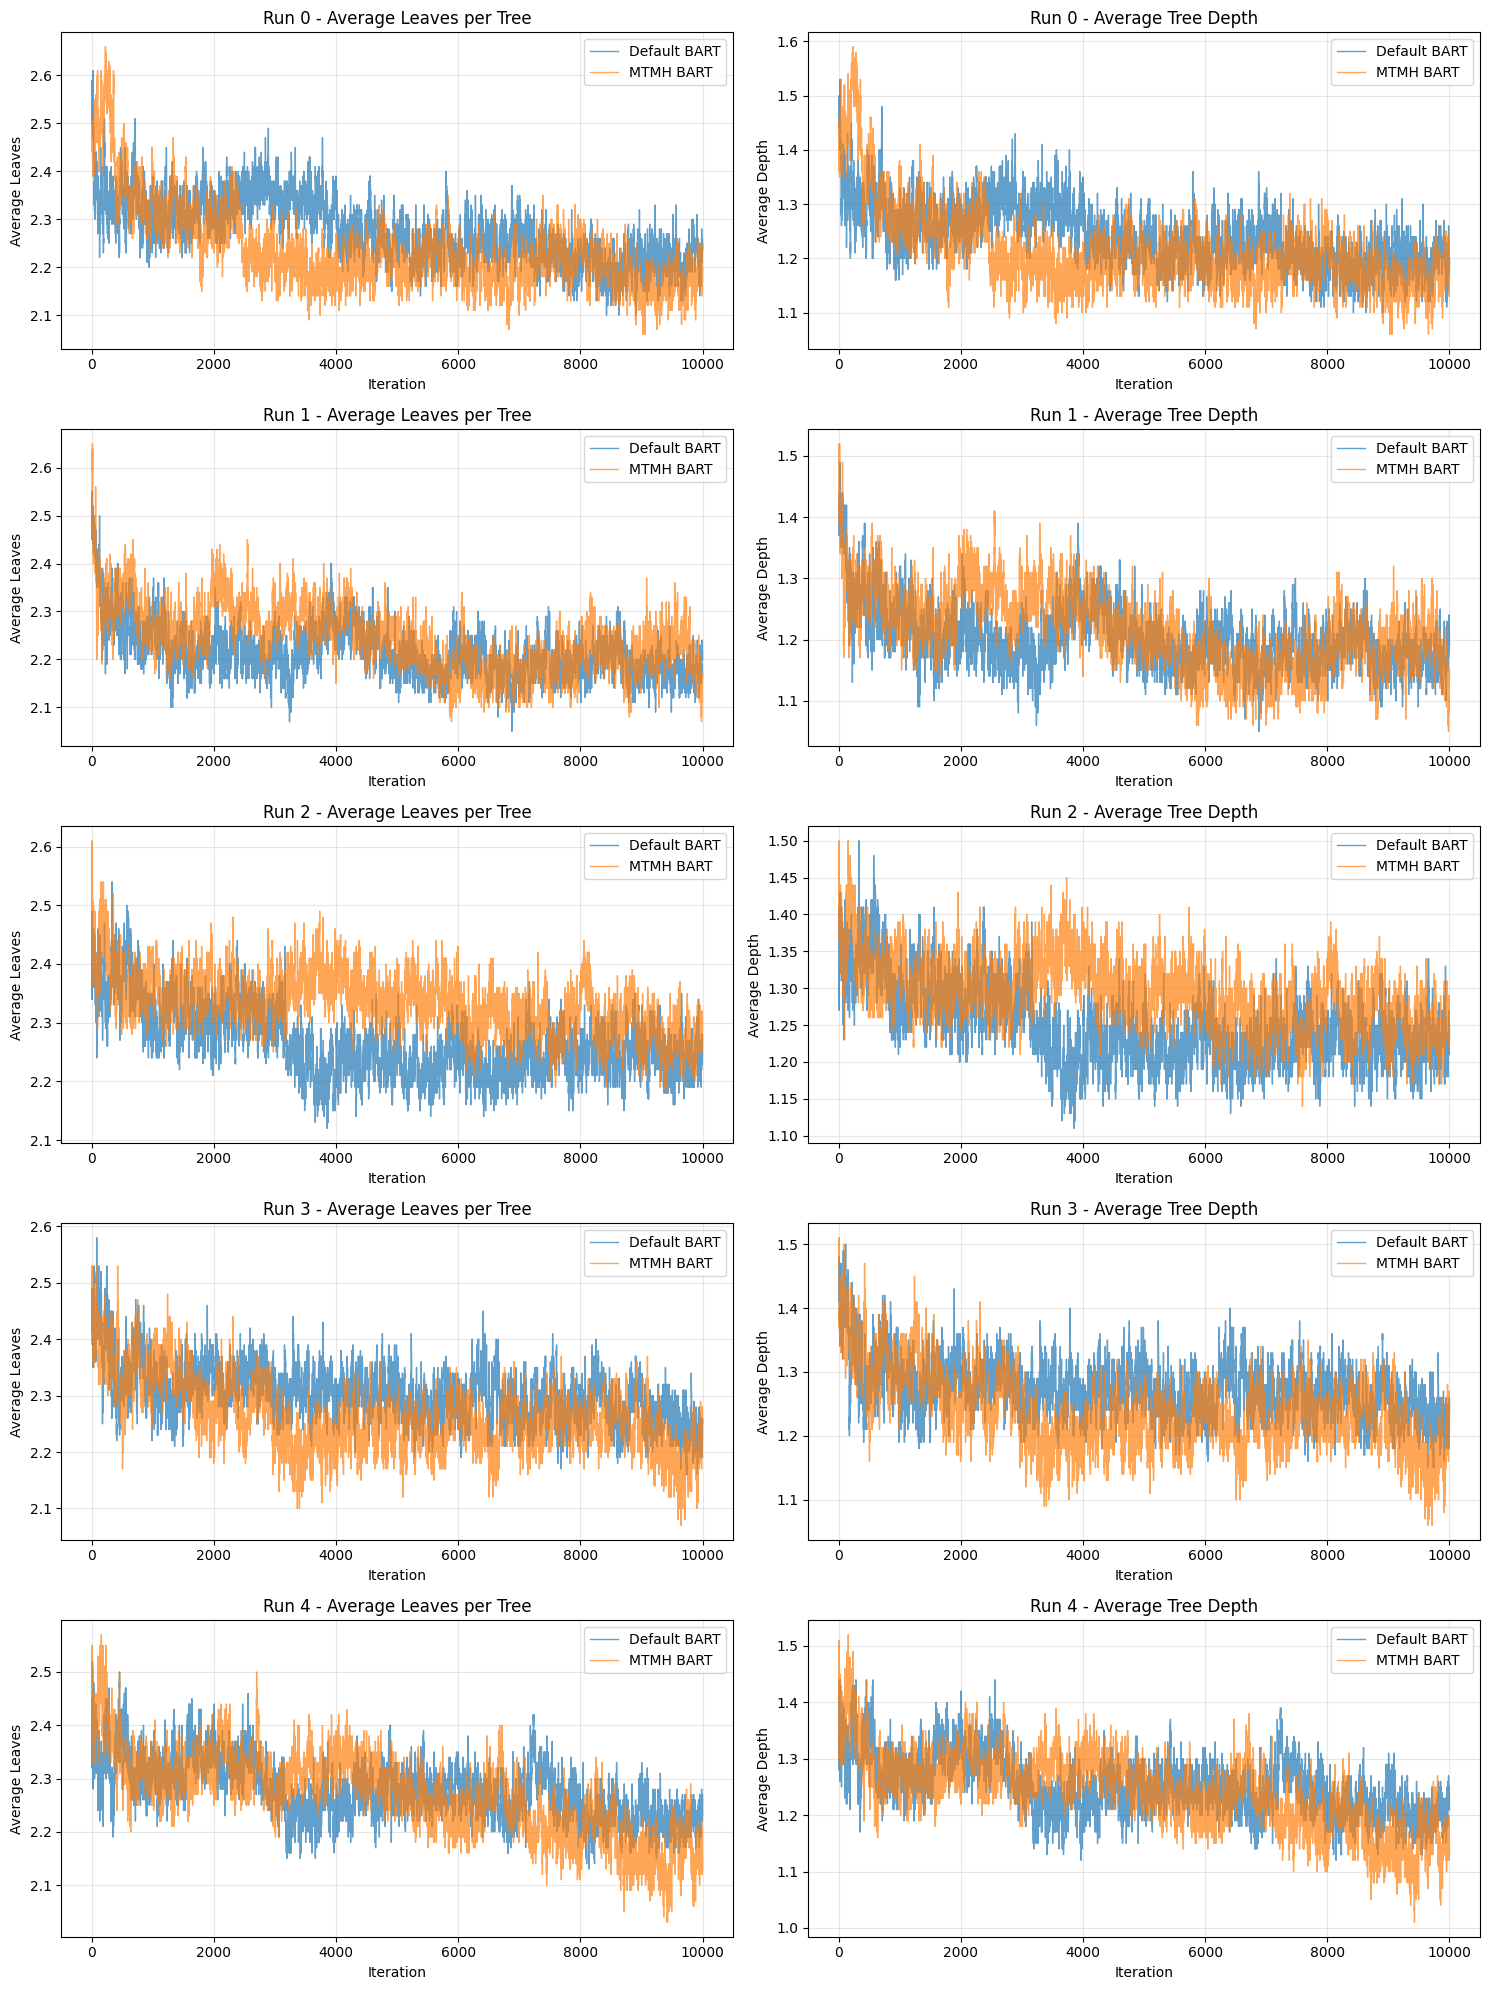

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Extract leaves and depths data for visualization
n_runs = experiment_results['metadata'].item()['n_runs']

fig, axes = plt.subplots(n_runs, 2, figsize=(15, 4*n_runs))
if n_runs == 1:
    axes = axes.reshape(1, -1)

for run_id in range(n_runs):
    # Extract data for this run
    default_leaves = experiment_results['default'].item()['leaves'][run_id][0]
    mtmh_leaves = experiment_results['mtmh'].item()['leaves'][run_id][0]
    default_depths = experiment_results['default'].item()['depths'][run_id][0]
    mtmh_depths = experiment_results['mtmh'].item()['depths'][run_id][0]
    
    # Plot leaves (left column)
    axes[run_id, 0].plot(default_leaves, label='Default BART', alpha=0.7, linewidth=1)
    axes[run_id, 0].plot(mtmh_leaves, label='MTMH BART', alpha=0.7, linewidth=1)
    axes[run_id, 0].set_title(f'Run {run_id} - Average Leaves per Tree')
    axes[run_id, 0].set_xlabel('Iteration')
    axes[run_id, 0].set_ylabel('Average Leaves')
    axes[run_id, 0].legend()
    axes[run_id, 0].grid(True, alpha=0.3)
    
    # Plot depths (right column)
    axes[run_id, 1].plot(default_depths, label='Default BART', alpha=0.7, linewidth=1)
    axes[run_id, 1].plot(mtmh_depths, label='MTMH BART', alpha=0.7, linewidth=1)
    axes[run_id, 1].set_title(f'Run {run_id} - Average Tree Depth')
    axes[run_id, 1].set_xlabel('Iteration')
    axes[run_id, 1].set_ylabel('Average Depth')
    axes[run_id, 1].legend()
    axes[run_id, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

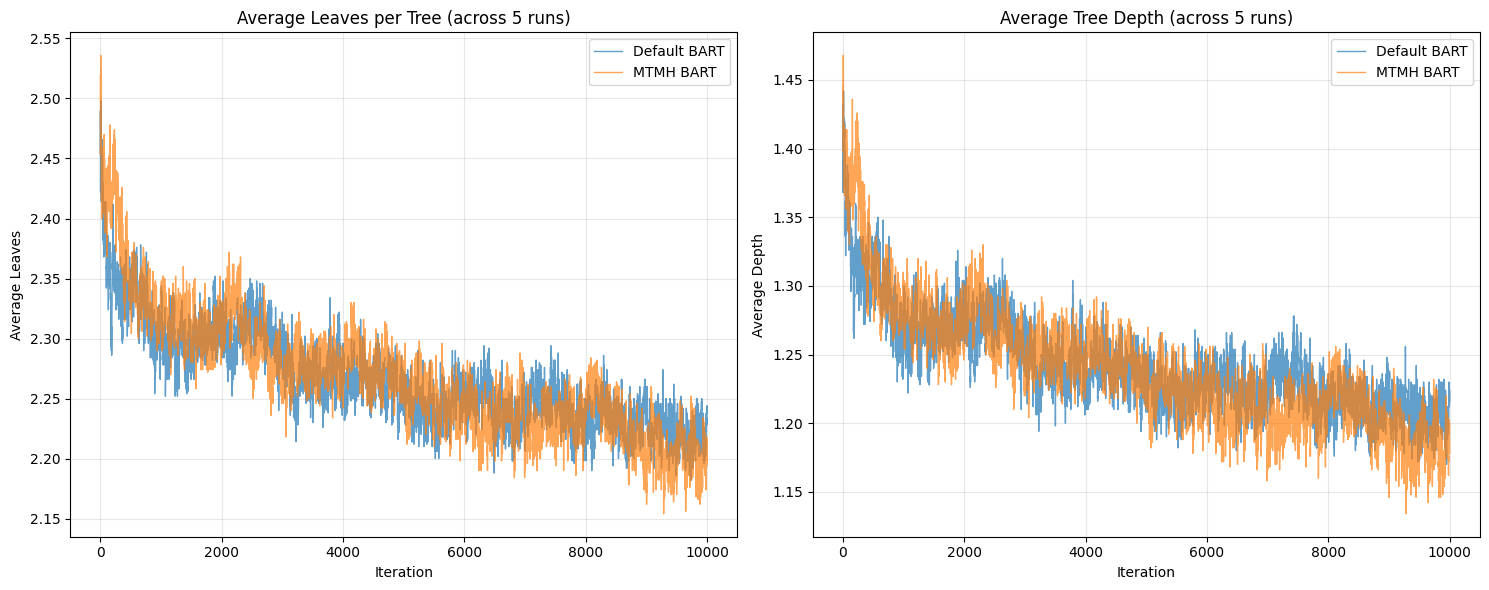

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Extract data across all runs
n_runs = experiment_results['metadata'].item()['n_runs']

# Collect all runs data
default_leaves_all = []
mtmh_leaves_all = []
default_depths_all = []
mtmh_depths_all = []

for run_id in range(n_runs):
    default_leaves_all.append(experiment_results['default'].item()['leaves'][run_id][0])
    mtmh_leaves_all.append(experiment_results['mtmh'].item()['leaves'][run_id][0])
    default_depths_all.append(experiment_results['default'].item()['depths'][run_id][0])
    mtmh_depths_all.append(experiment_results['mtmh'].item()['depths'][run_id][0])

# Convert to numpy arrays
default_leaves_all = np.array(default_leaves_all)  # Shape: (n_runs, n_iterations)
mtmh_leaves_all = np.array(mtmh_leaves_all)
default_depths_all = np.array(default_depths_all)
mtmh_depths_all = np.array(mtmh_depths_all)

# Calculate mean and std across runs
default_leaves_mean = np.mean(default_leaves_all, axis=0)
mtmh_leaves_mean = np.mean(mtmh_leaves_all, axis=0)

default_depths_mean = np.mean(default_depths_all, axis=0)
mtmh_depths_mean = np.mean(mtmh_depths_all, axis=0)

# Create iteration axis
iterations = np.arange(len(default_leaves_mean))

# Plot averaged results with error bands
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot leaves
ax1.plot(iterations, default_leaves_mean, label='Default BART', alpha=0.7, linewidth=1)
ax1.plot(iterations, mtmh_leaves_mean, label='MTMH BART', alpha=0.7, linewidth=1)
ax1.set_title(f'Average Leaves per Tree (across {n_runs} runs)')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Average Leaves')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot depths
ax2.plot(iterations, default_depths_mean, label='Default BART', alpha=0.7, linewidth=1)
ax2.plot(iterations, mtmh_depths_mean, label='MTMH BART', alpha=0.7, linewidth=1)
ax2.set_title(f'Average Tree Depth (across {n_runs} runs)')
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Average Depth')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Sigmas & RMSE

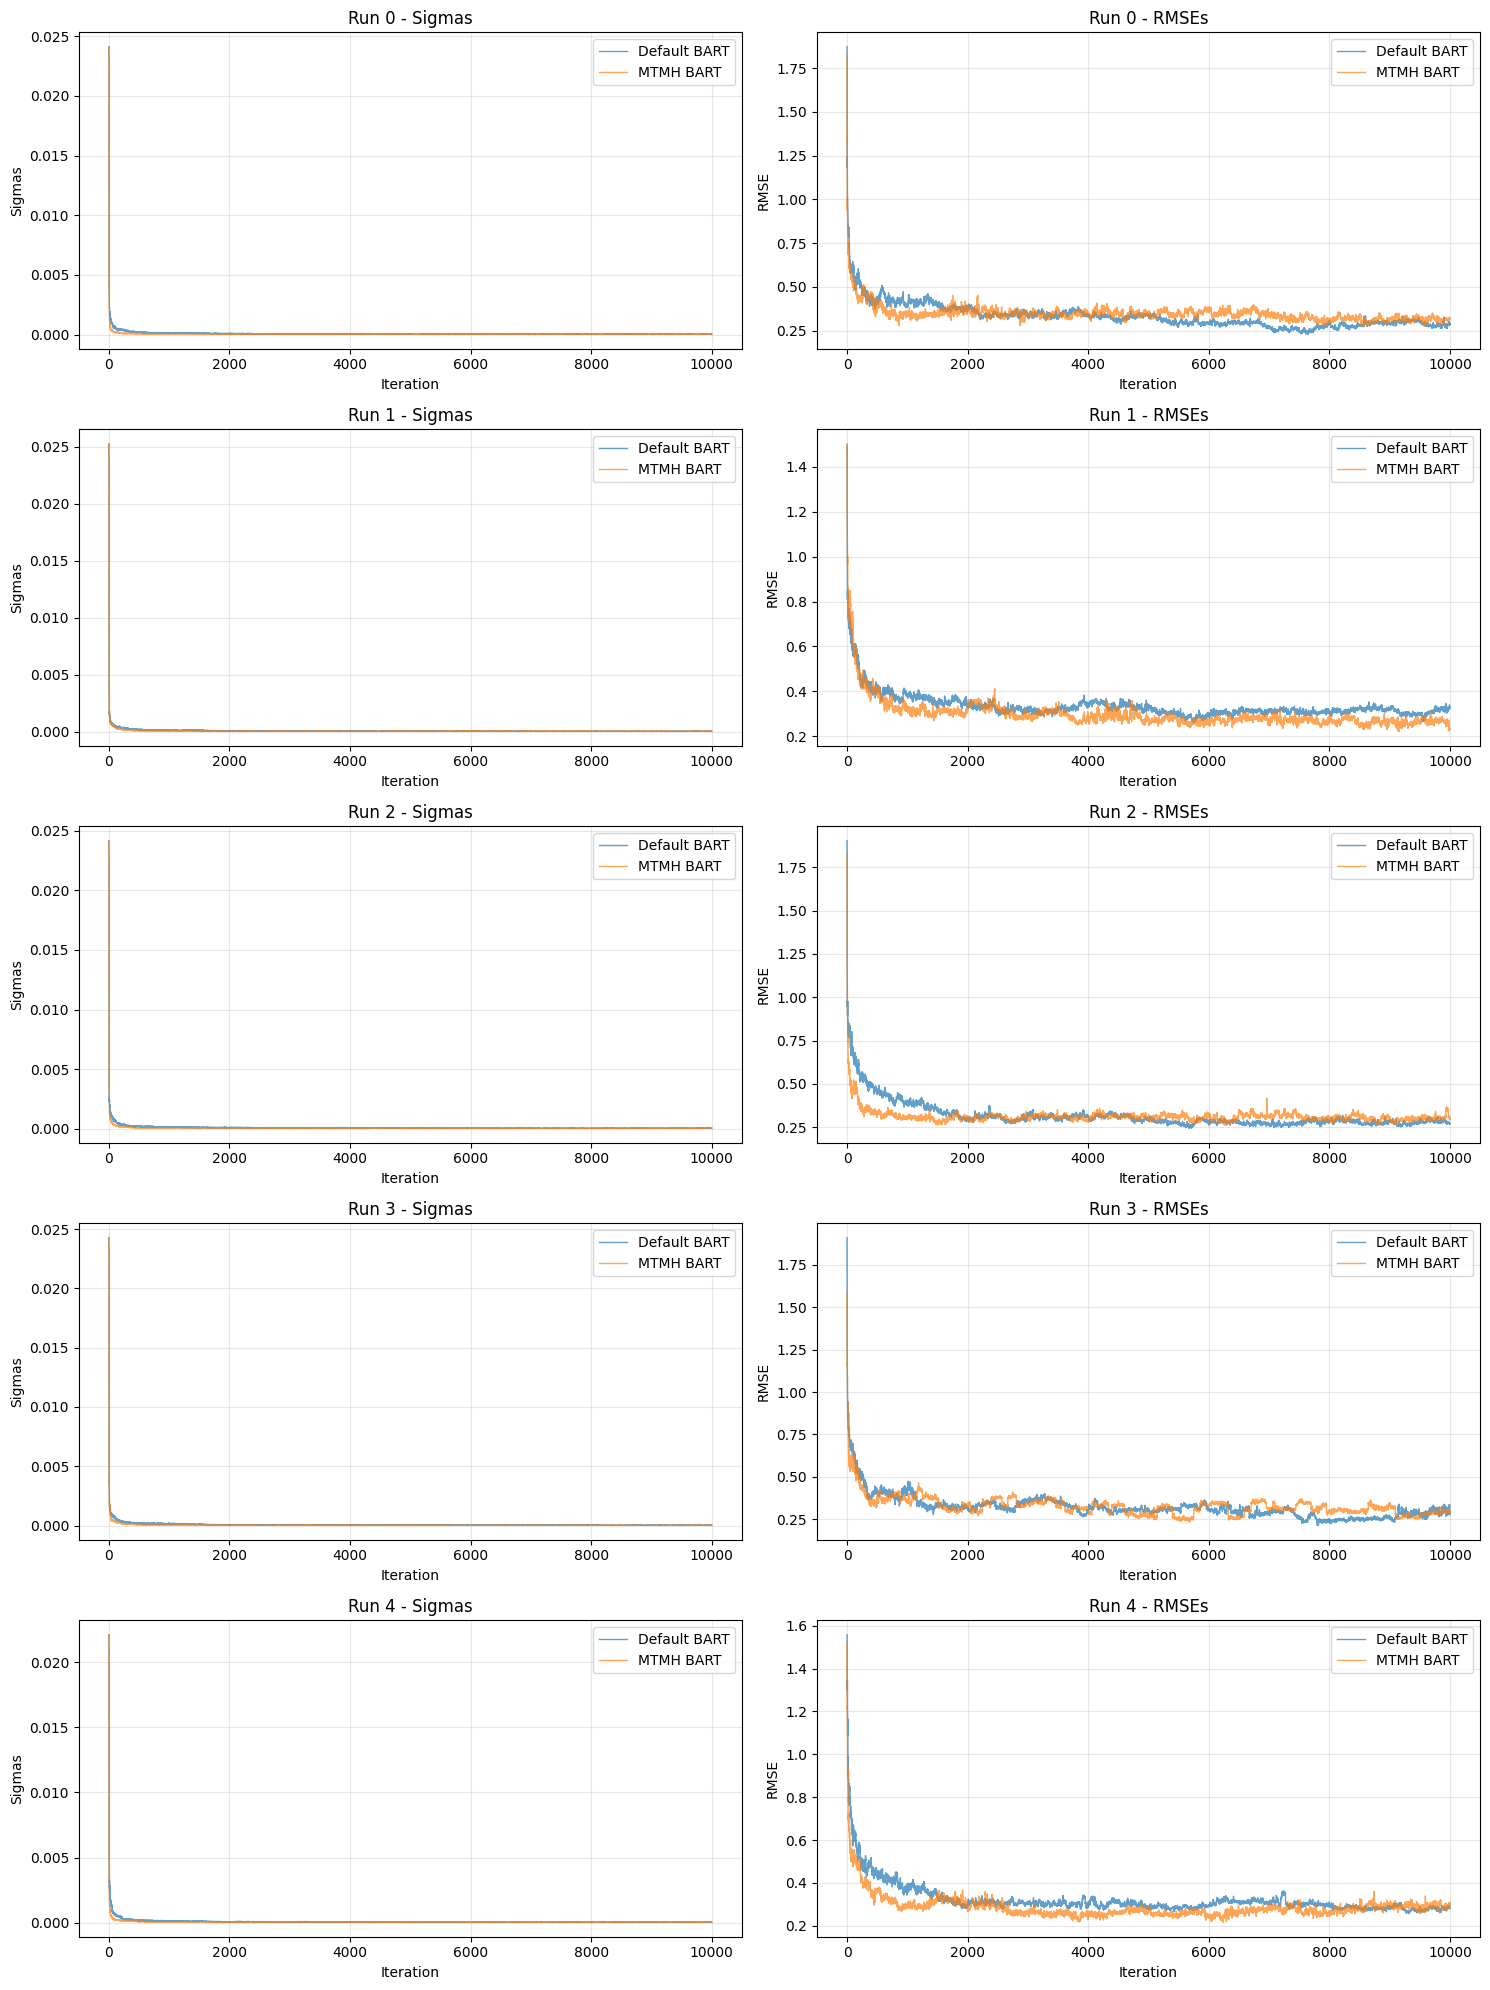

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Extract sigmas and rmses data for visualization
n_runs = experiment_results['metadata'].item()['n_runs']

fig, axes = plt.subplots(n_runs, 2, figsize=(15, 4*n_runs))
if n_runs == 1:
    axes = axes.reshape(1, -1)

for run_id in range(n_runs):
    # Extract data for this run
    default_sigmas = experiment_results['default'].item()['sigmas'][run_id][0]
    mtmh_sigmas = experiment_results['mtmh'].item()['sigmas'][run_id][0]
    default_rmses = experiment_results['default'].item()['rmses'][run_id][0]
    mtmh_rmses = experiment_results['mtmh'].item()['rmses'][run_id][0]

    # Plot sigmas (left column)
    axes[run_id, 0].plot(default_sigmas, label='Default BART', alpha=0.7, linewidth=1)
    axes[run_id, 0].plot(mtmh_sigmas, label='MTMH BART', alpha=0.7, linewidth=1)
    axes[run_id, 0].set_title(f'Run {run_id} - Sigmas')
    axes[run_id, 0].set_xlabel('Iteration')
    axes[run_id, 0].set_ylabel('Sigmas')
    axes[run_id, 0].legend()
    axes[run_id, 0].grid(True, alpha=0.3)

    # Plot rmses (right column)
    axes[run_id, 1].plot(default_rmses, label='Default BART', alpha=0.7, linewidth=1)
    axes[run_id, 1].plot(mtmh_rmses, label='MTMH BART', alpha=0.7, linewidth=1)
    axes[run_id, 1].set_title(f'Run {run_id} - RMSEs')
    axes[run_id, 1].set_xlabel('Iteration')
    axes[run_id, 1].set_ylabel('RMSE')
    axes[run_id, 1].legend()
    axes[run_id, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

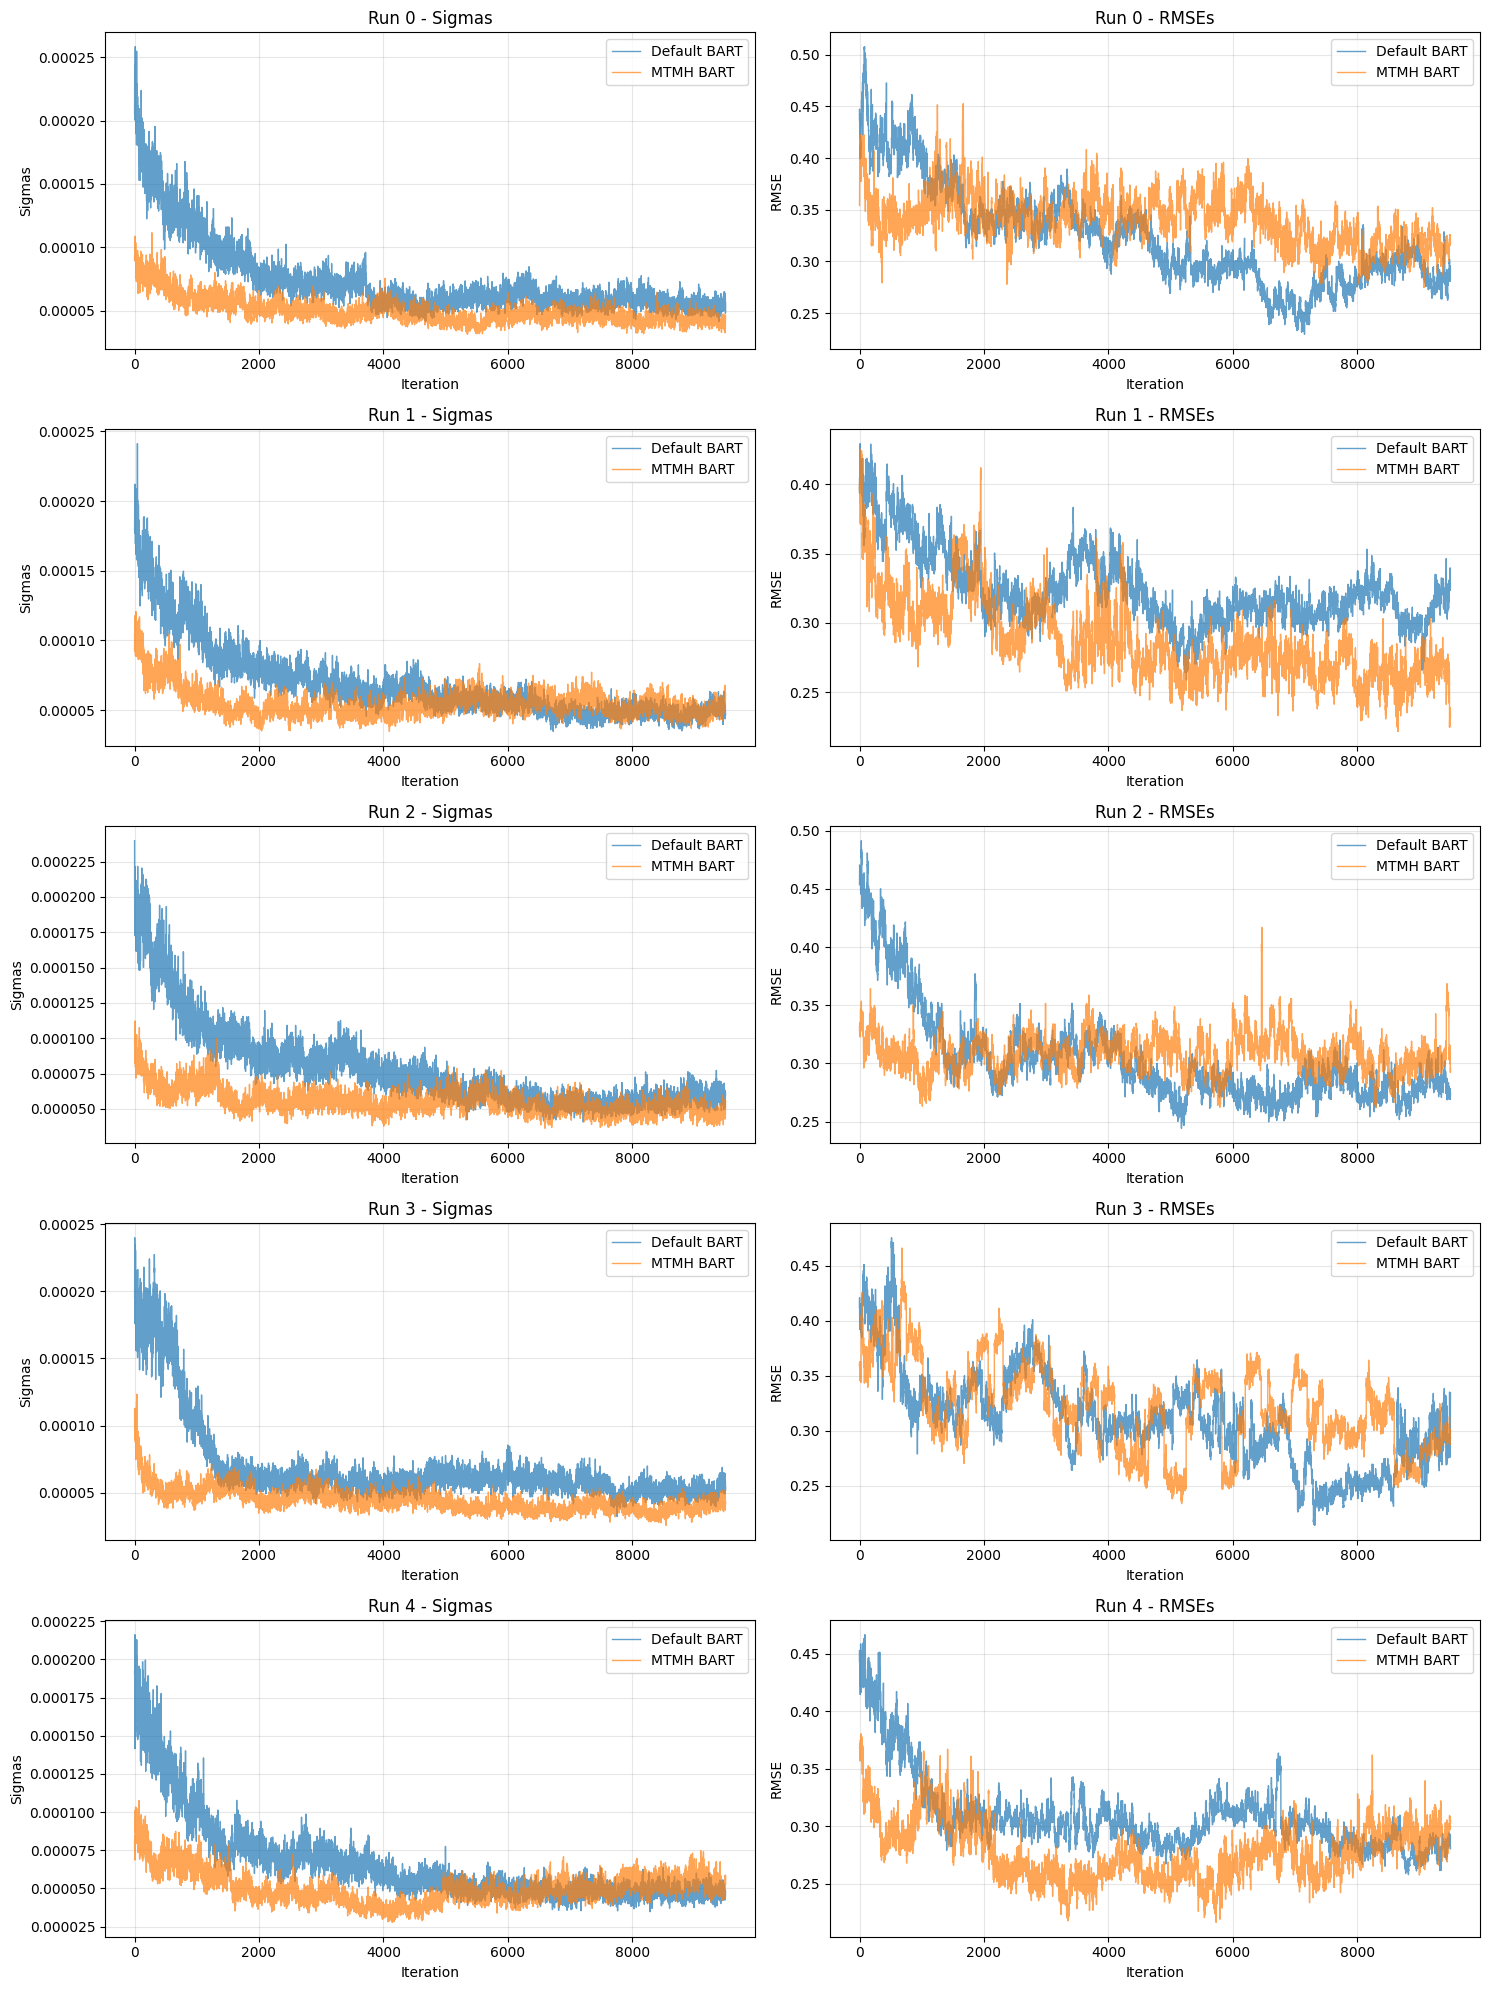

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Extract sigmas and rmses data for visualization
n_runs = experiment_results['metadata'].item()['n_runs']

fig, axes = plt.subplots(n_runs, 2, figsize=(15, 4*n_runs))
if n_runs == 1:
    axes = axes.reshape(1, -1)

for run_id in range(n_runs):
    # Extract data for this run
    default_sigmas = experiment_results['default'].item()['sigmas'][run_id][0]
    mtmh_sigmas = experiment_results['mtmh'].item()['sigmas'][run_id][0]
    default_rmses = experiment_results['default'].item()['rmses'][run_id][0]
    mtmh_rmses = experiment_results['mtmh'].item()['rmses'][run_id][0]

    # Plot sigmas (left column)
    axes[run_id, 0].plot(default_sigmas[500:], label='Default BART', alpha=0.7, linewidth=1)
    axes[run_id, 0].plot(mtmh_sigmas[500:], label='MTMH BART', alpha=0.7, linewidth=1)
    axes[run_id, 0].set_title(f'Run {run_id} - Sigmas')
    axes[run_id, 0].set_xlabel('Iteration')
    axes[run_id, 0].set_ylabel('Sigmas')
    axes[run_id, 0].legend()
    axes[run_id, 0].grid(True, alpha=0.3)

    # Plot rmses (right column)
    axes[run_id, 1].plot(default_rmses[500:], label='Default BART', alpha=0.7, linewidth=1)
    axes[run_id, 1].plot(mtmh_rmses[500:], label='MTMH BART', alpha=0.7, linewidth=1)
    axes[run_id, 1].set_title(f'Run {run_id} - RMSEs')
    axes[run_id, 1].set_xlabel('Iteration')
    axes[run_id, 1].set_ylabel('RMSE')
    axes[run_id, 1].legend()
    axes[run_id, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

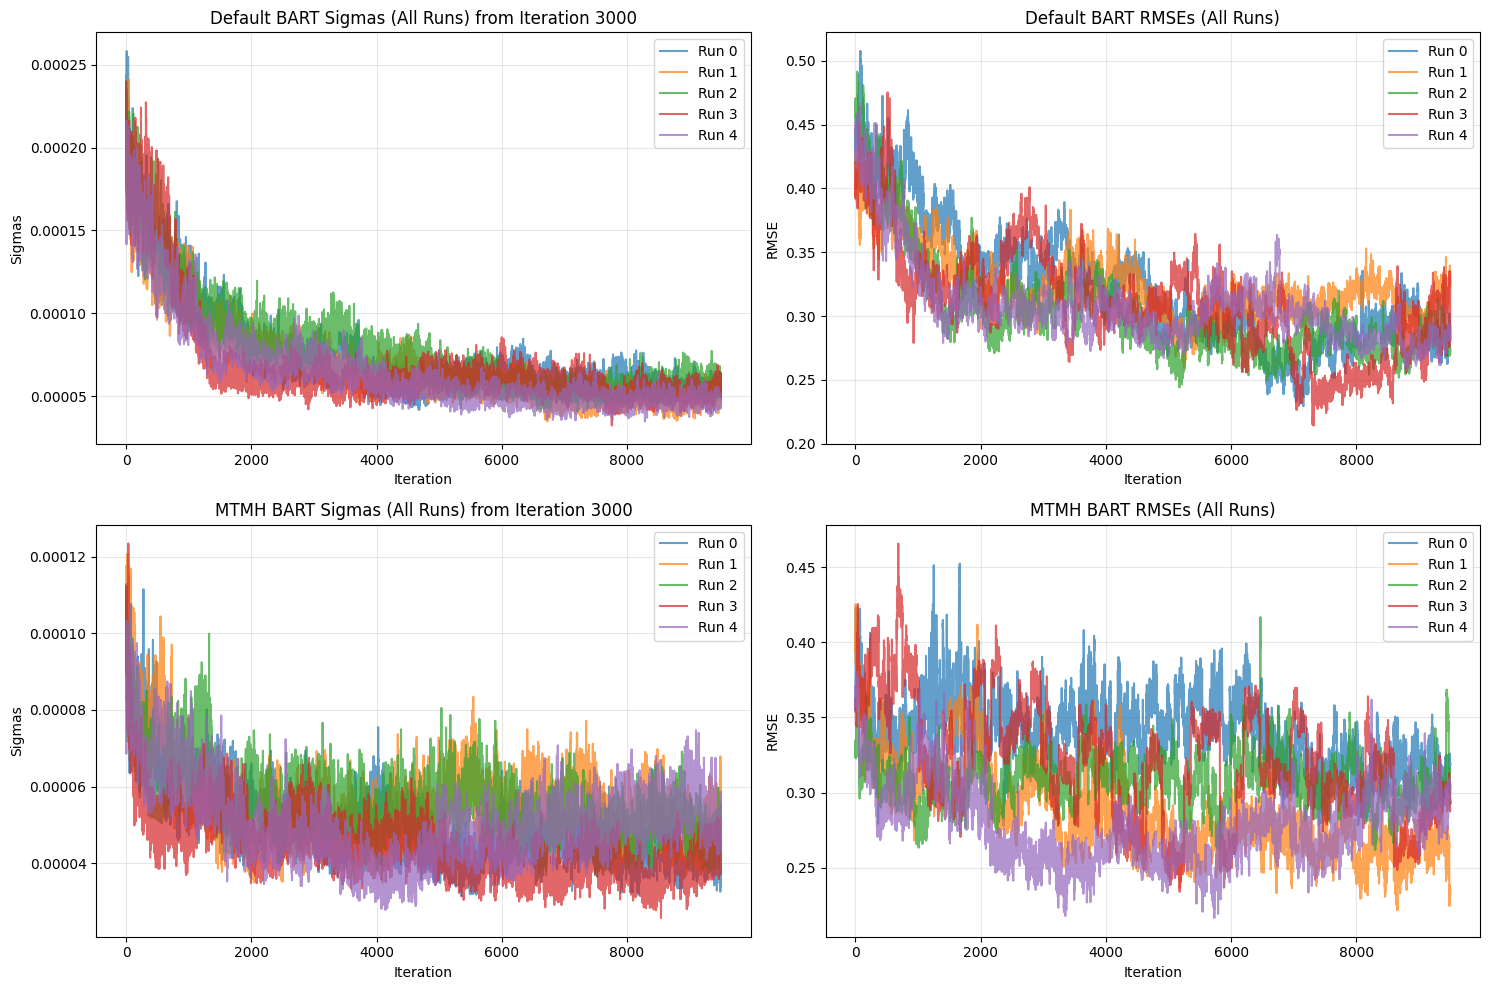

In [17]:
import matplotlib.pyplot as plt
import numpy as np

n_runs = experiment_results['metadata'].item()['n_runs']

default_sigmas_all = []
mtmh_sigmas_all = []
default_rmses_all = []
mtmh_rmses_all = []

for run_id in range(n_runs):
    default_sigmas_all.append(experiment_results['default'].item()['sigmas'][run_id][0][500:])
    mtmh_sigmas_all.append(experiment_results['mtmh'].item()['sigmas'][run_id][0][500:])
    default_rmses_all.append(experiment_results['default'].item()['rmses'][run_id][0][500:])
    mtmh_rmses_all.append(experiment_results['mtmh'].item()['rmses'][run_id][0][500:])

default_sigmas_all = np.array(default_sigmas_all)
mtmh_sigmas_all = np.array(mtmh_sigmas_all)
default_rmses_all = np.array(default_rmses_all)
mtmh_rmses_all = np.array(mtmh_rmses_all)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

iterations = np.arange(default_sigmas_all.shape[1])
# Top left: Default BART sigmas (all runs)
for run_id in range(n_runs):
    axes[0, 0].plot(iterations, default_sigmas_all[run_id], label=f'Run {run_id}', alpha=0.7)
axes[0, 0].set_title('Default BART Sigmas (All Runs) from Iteration 3000')
axes[0, 0].set_xlabel('Iteration')
axes[0, 0].set_ylabel('Sigmas')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Bottom left: MTMH BART sigmas (all runs)
for run_id in range(n_runs):
    axes[1, 0].plot(iterations, mtmh_sigmas_all[run_id], label=f'Run {run_id}', alpha=0.7)
axes[1, 0].set_title('MTMH BART Sigmas (All Runs) from Iteration 3000')
axes[1, 0].set_xlabel('Iteration')
axes[1, 0].set_ylabel('Sigmas')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

iterations = np.arange(default_rmses_all.shape[1])
# Top right: Default BART RMSEs (all runs)
for run_id in range(n_runs):
    axes[0, 1].plot(iterations, default_rmses_all[run_id], label=f'Run {run_id}', alpha=0.7)
axes[0, 1].set_title('Default BART RMSEs (All Runs)')
axes[0, 1].set_xlabel('Iteration')
axes[0, 1].set_ylabel('RMSE')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Bottom right: MTMH BART RMSEs (all runs)
for run_id in range(n_runs):
    axes[1, 1].plot(iterations, mtmh_rmses_all[run_id], label=f'Run {run_id}', alpha=0.7)
axes[1, 1].set_title('MTMH BART RMSEs (All Runs)')
axes[1, 1].set_xlabel('Iteration')
axes[1, 1].set_ylabel('RMSE')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

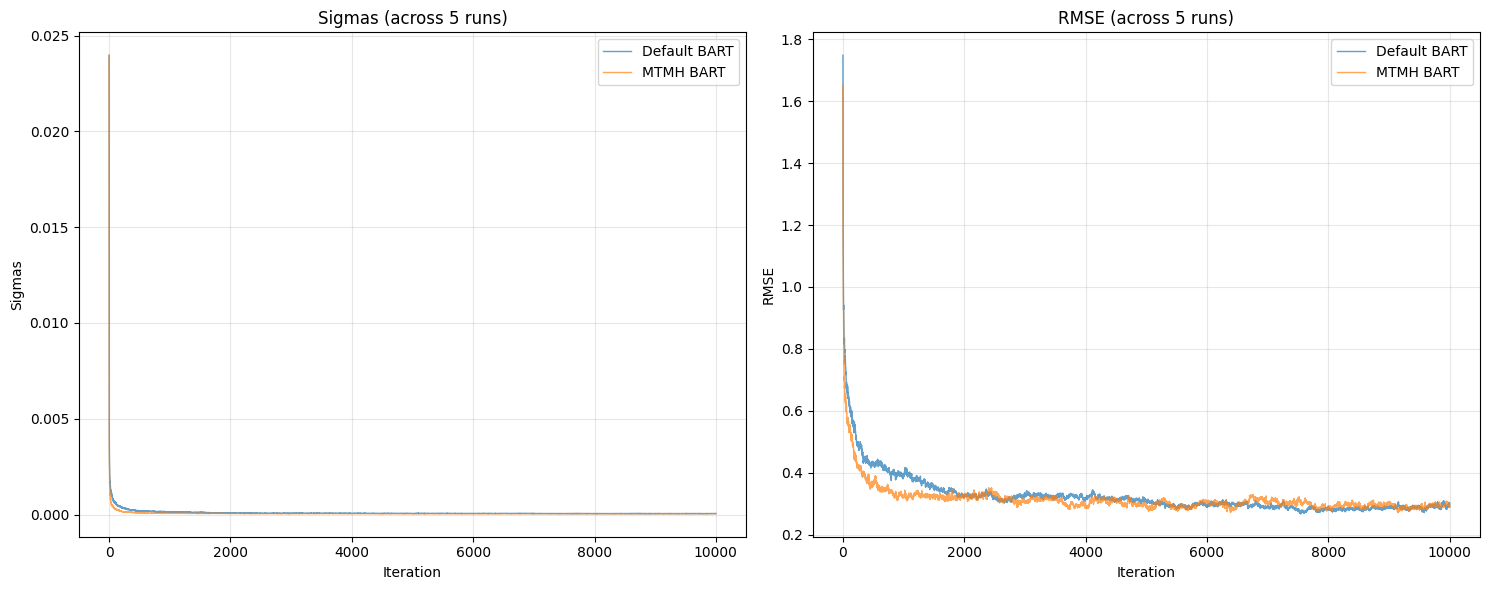

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Extract data across all runs
n_runs = experiment_results['metadata'].item()['n_runs']

# Collect all runs data
default_sigmas_all = []
mtmh_sigmas_all = []
default_rmses_all = []
mtmh_rmses_all = []

for run_id in range(n_runs):
    default_sigmas_all.append(experiment_results['default'].item()['sigmas'][run_id][0])
    mtmh_sigmas_all.append(experiment_results['mtmh'].item()['sigmas'][run_id][0])
    default_rmses_all.append(experiment_results['default'].item()['rmses'][run_id][0])
    mtmh_rmses_all.append(experiment_results['mtmh'].item()['rmses'][run_id][0])

# Convert to numpy arrays
default_sigmas_all = np.array(default_sigmas_all)  # Shape: (n_runs, n_iterations)
mtmh_sigmas_all = np.array(mtmh_sigmas_all)
default_rmses_all = np.array(default_rmses_all)
mtmh_rmses_all = np.array(mtmh_rmses_all)

# Calculate mean and std across runs
default_sigmas_mean = np.mean(default_sigmas_all, axis=0)
mtmh_sigmas_mean = np.mean(mtmh_sigmas_all, axis=0)

default_rmses_mean = np.mean(default_rmses_all, axis=0)
mtmh_rmses_mean = np.mean(mtmh_rmses_all, axis=0)

# Plot averaged results with error bands
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot sigmas
iterations = np.arange(len(default_sigmas_mean))
ax1.plot(iterations, default_sigmas_mean, label='Default BART', alpha=0.7, linewidth=1)
ax1.plot(iterations, mtmh_sigmas_mean, label='MTMH BART', alpha=0.7, linewidth=1)
ax1.set_title(f'Sigmas (across {n_runs} runs)')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Sigmas')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot rmses
iterations = np.arange(len(default_rmses_mean))
ax2.plot(iterations, default_rmses_mean, label='Default BART', alpha=0.7, linewidth=1)
ax2.plot(iterations, mtmh_rmses_mean, label='MTMH BART', alpha=0.7, linewidth=1)
ax2.set_title(f'RMSE (across {n_runs} runs)')
ax2.set_xlabel('Iteration')
ax2.set_ylabel('RMSE')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

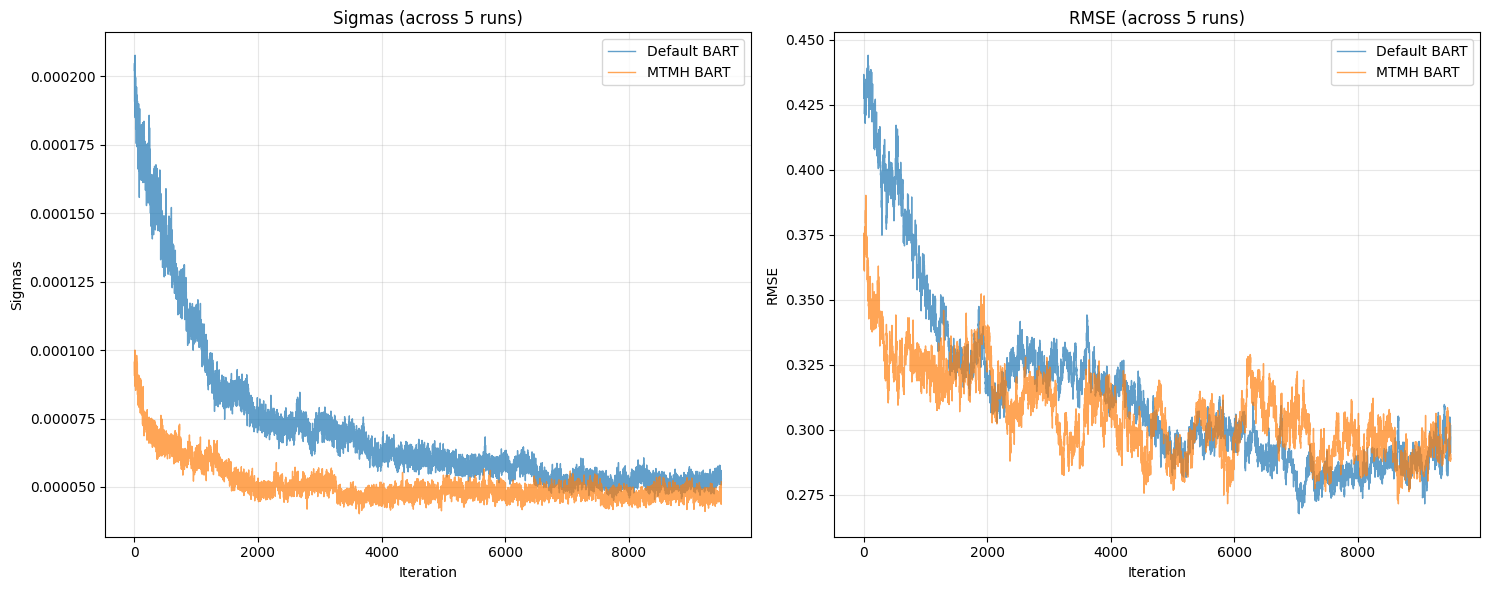

In [19]:
# Extract data after burn-in
default_sigmas_mean = default_sigmas_mean[500:]
mtmh_sigmas_mean = mtmh_sigmas_mean[500:]

default_rmses_mean = default_rmses_mean[500:]
mtmh_rmses_mean = mtmh_rmses_mean[500:]

# Plot averaged results with error bands
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot sigmas
iterations = np.arange(len(default_sigmas_mean))
ax1.plot(iterations, default_sigmas_mean, label='Default BART', alpha=0.7, linewidth=1)
ax1.plot(iterations, mtmh_sigmas_mean, label='MTMH BART', alpha=0.7, linewidth=1)
ax1.set_title(f'Sigmas (across {n_runs} runs)')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Sigmas')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot rmses
iterations = np.arange(len(default_rmses_mean))
ax2.plot(iterations, default_rmses_mean, label='Default BART', alpha=0.7, linewidth=1)
ax2.plot(iterations, mtmh_rmses_mean, label='MTMH BART', alpha=0.7, linewidth=1)
ax2.set_title(f'RMSE (across {n_runs} runs)')
ax2.set_xlabel('Iteration')
ax2.set_ylabel('RMSE')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Pairwise Distance

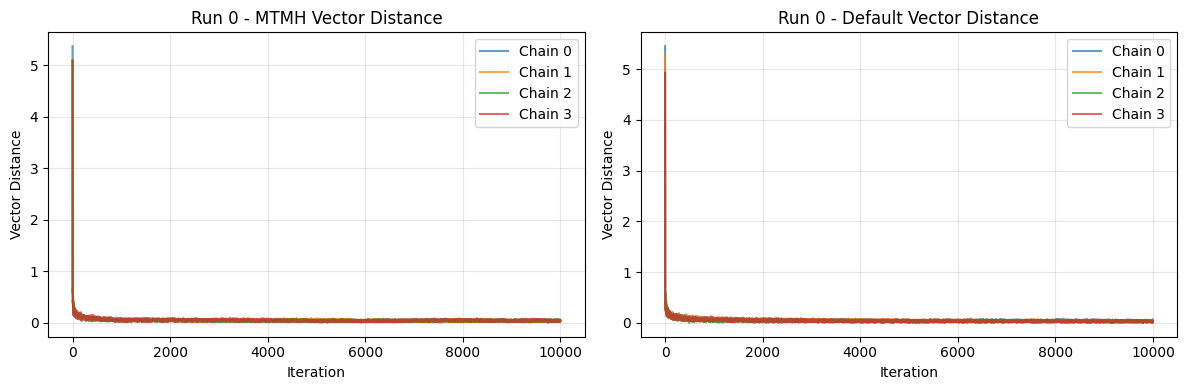

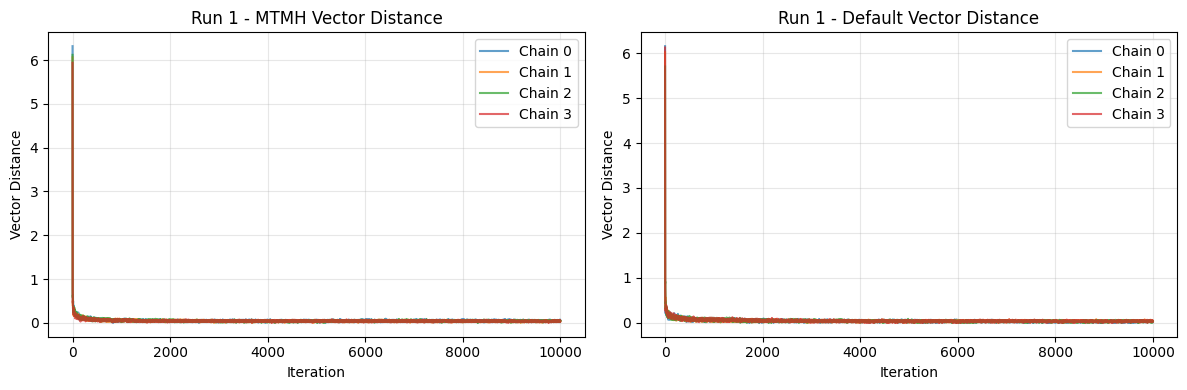

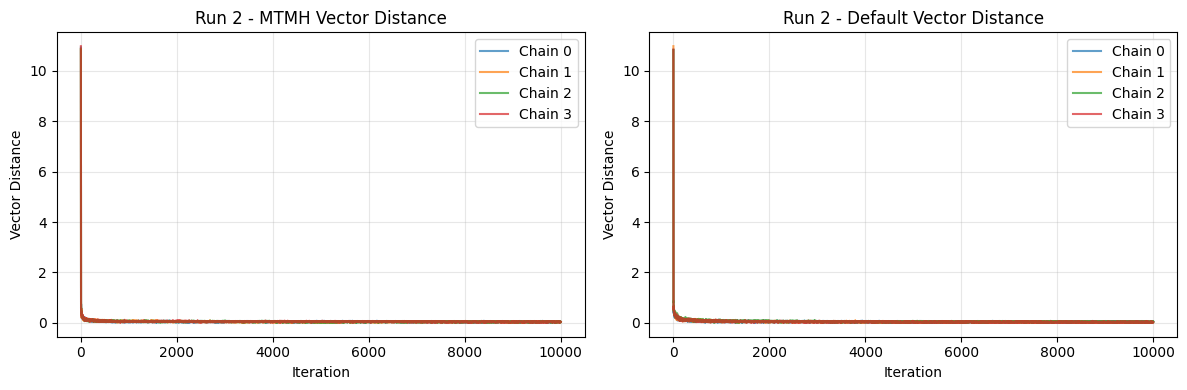

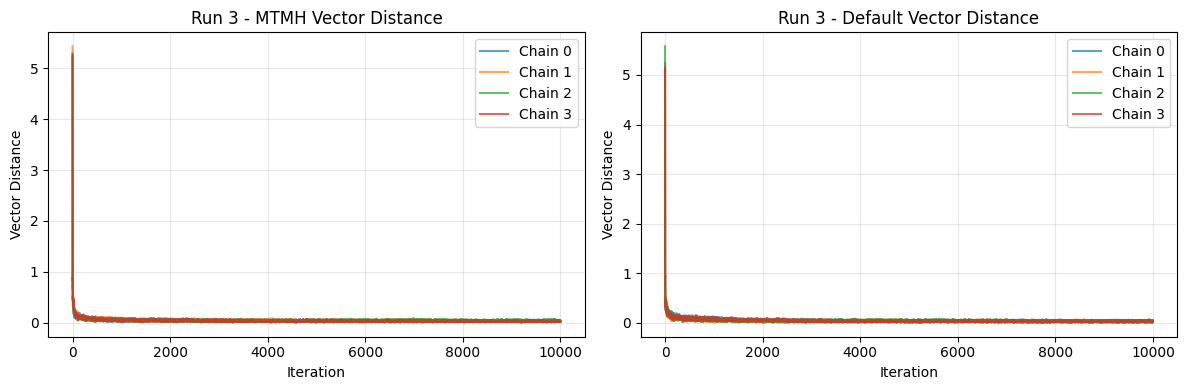

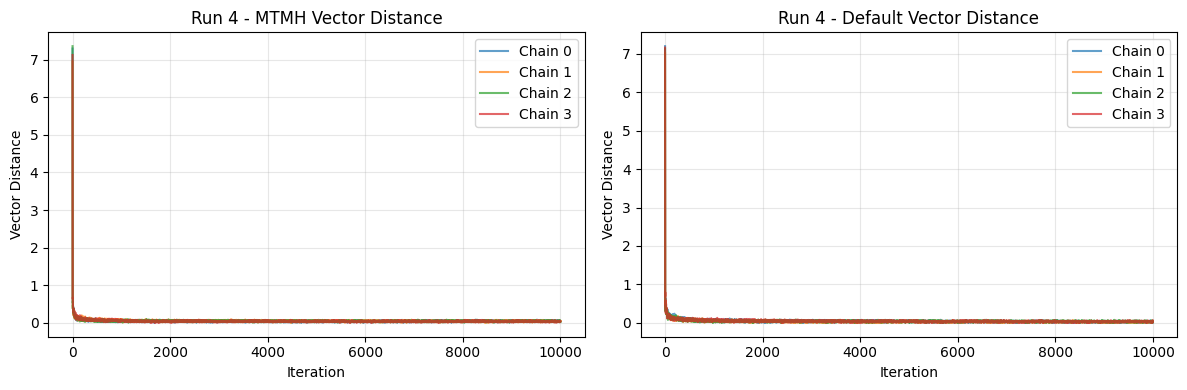

In [20]:
import matplotlib.pyplot as plt
import numpy as np

default_vector = experiment_results['default'].item()['vector_distances']  # [n_runs, n_chains, n_iter]
mtmh_vector = experiment_results['mtmh'].item()['vector_distances']
n_runs = experiment_results['metadata'].item()['n_runs']
n_chains = experiment_results['metadata'].item()['n_chains']
n_iter = default_vector.shape[2]

for run_id in range(n_runs):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    # MTMH
    for chain_id in range(n_chains):
        axes[0].plot(mtmh_vector[run_id, chain_id], label=f'Chain {chain_id}', alpha=0.7)
    axes[0].set_title(f'Run {run_id} - MTMH Vector Distance')
    axes[0].set_xlabel('Iteration')
    axes[0].set_ylabel('Vector Distance')
    axes[0].legend()
    axes[0].grid(alpha=0.3)
    # Default
    for chain_id in range(n_chains):
        axes[1].plot(default_vector[run_id, chain_id], label=f'Chain {chain_id}', alpha=0.7)
    axes[1].set_title(f'Run {run_id} - Default Vector Distance')
    axes[1].set_xlabel('Iteration')
    axes[1].set_ylabel('Vector Distance')
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

In [21]:
# import matplotlib.pyplot as plt
# import numpy as np

# default_vector = experiment_results['default'].item()['subspace_distances']  # [n_runs, n_chains, n_iter]
# mtmh_vector = experiment_results['mtmh'].item()['subspace_distances']
# n_runs = experiment_results['metadata'].item()['n_runs']
# n_chains = experiment_results['metadata'].item()['n_chains']
# n_iter = default_vector.shape[2]

# for run_id in range(n_runs):
#     fig, axes = plt.subplots(1, 2, figsize=(12, 4))
#     # MTMH
#     for chain_id in range(n_chains):
#         axes[0].plot(mtmh_vector[run_id, chain_id], label=f'Chain {chain_id}', alpha=0.7)
#     axes[0].set_title(f'Run {run_id} - MTMH Subspace Distance')
#     axes[0].set_xlabel('Iteration')
#     axes[0].set_ylabel('Subspace Distance')
#     axes[0].legend()
#     axes[0].grid(alpha=0.3)
#     # Default
#     for chain_id in range(n_chains):
#         axes[1].plot(default_vector[run_id, chain_id], label=f'Chain {chain_id}', alpha=0.7)
#     axes[1].set_title(f'Run {run_id} - Default Subspace Distance')
#     axes[1].set_xlabel('Iteration')
#     axes[1].set_ylabel('Subspace Distance')
#     axes[1].legend()
#     axes[1].grid(alpha=0.3)
#     plt.tight_layout()
#     plt.show()

# KPSS Test

## Sigamas

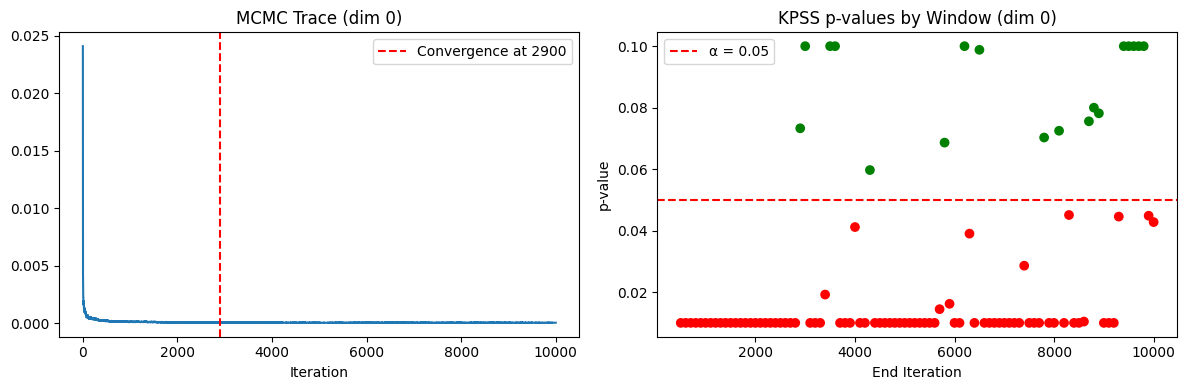

Run 0: Sigmas convergence_iter = 2900


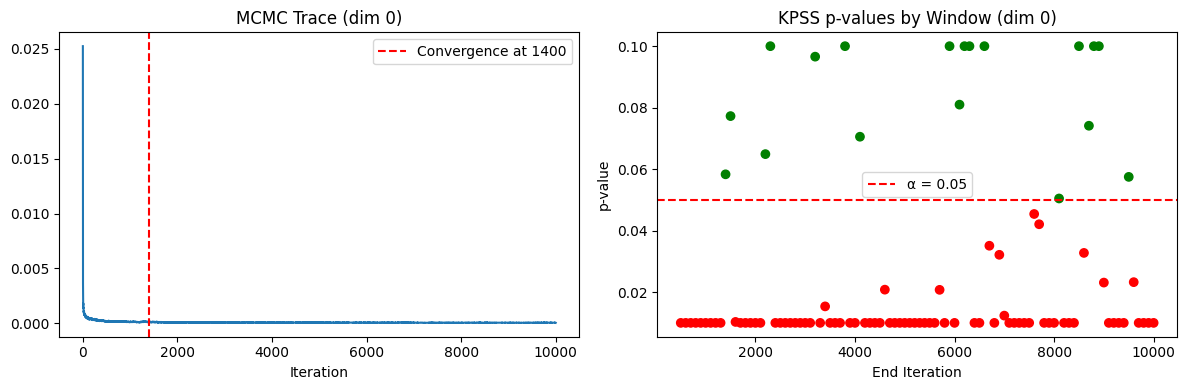

Run 1: Sigmas convergence_iter = 1400


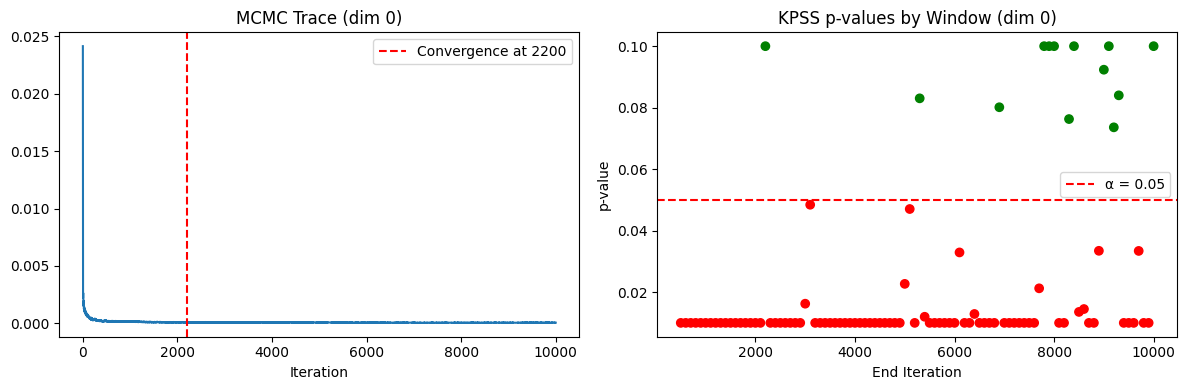

Run 2: Sigmas convergence_iter = 2200


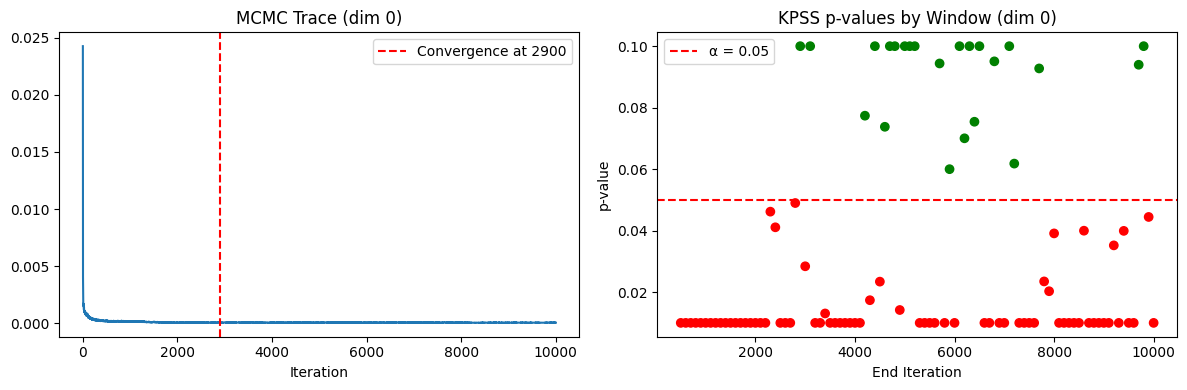

Run 3: Sigmas convergence_iter = 2900


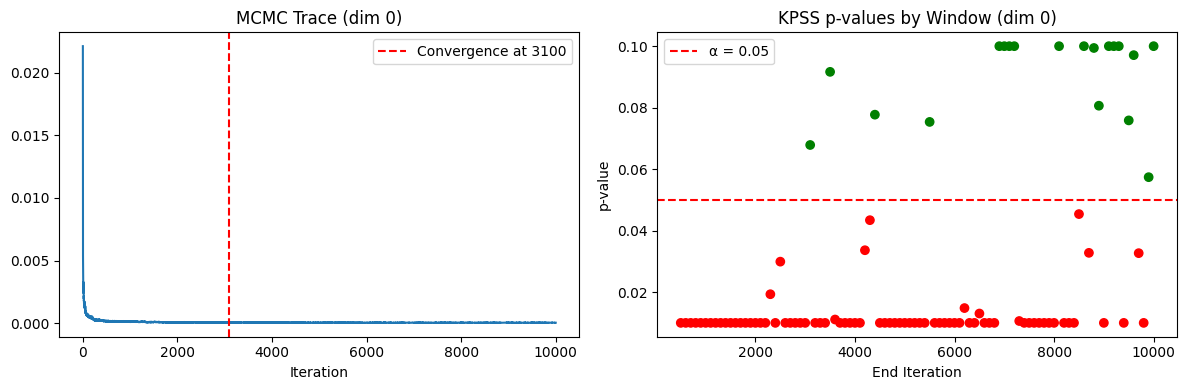

Run 4: Sigmas convergence_iter = 3100
All runs convergence_iter: [2900, 1400, 2200, 2900, 3100]


In [24]:
import numpy as np
from diagnosis import segmented_kpss_test

# default
sigmas = experiment_results['default'].item()['sigmas']  # shape: [n_runs, n_chains, n_iter]
n_runs, n_chains, _, _ = sigmas.shape

window_size = 500
step = 100
alpha = 0.05

convergence_iters = []
for run_id in range(n_runs):
    chain_sigmas = sigmas[run_id, 0]
    result = segmented_kpss_test(chain_sigmas, window_size=window_size, step=step, alpha=alpha)
    convergence_iters.append(result['convergence_iteration'])
    print(f"Run {run_id}: Sigmas convergence_iter = {result['convergence_iteration']}")

print("All runs convergence_iter:", convergence_iters)

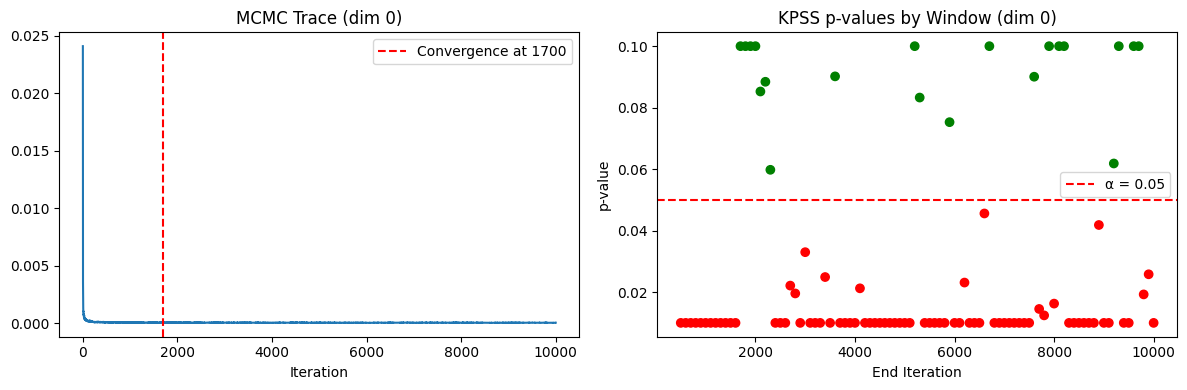

Run 0: Sigmas convergence_iter = 1700


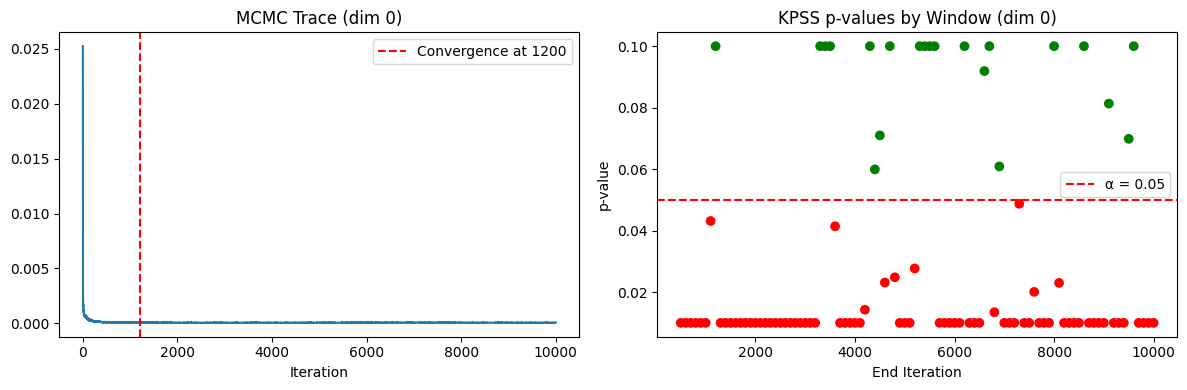

Run 1: Sigmas convergence_iter = 1200


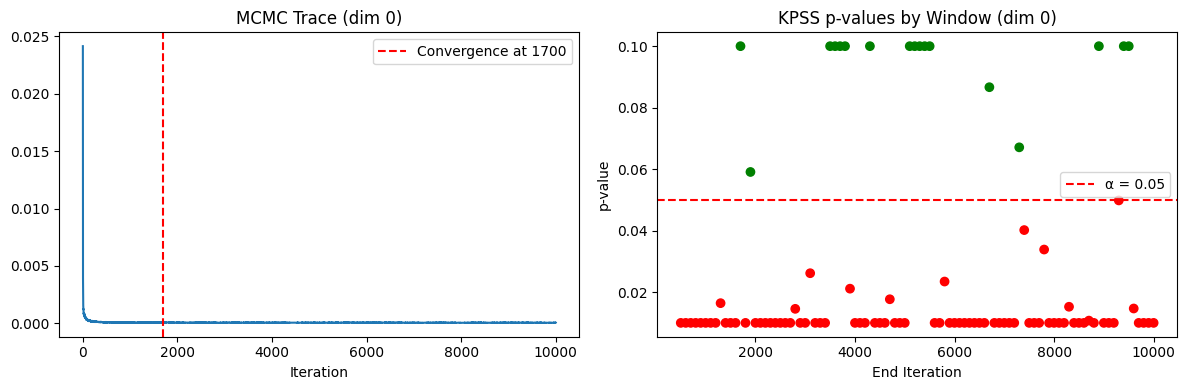

Run 2: Sigmas convergence_iter = 1700


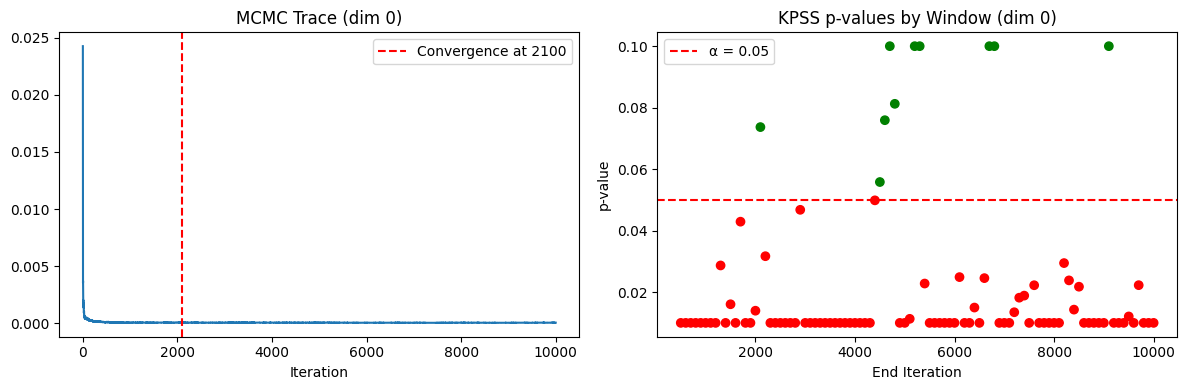

Run 3: Sigmas convergence_iter = 2100


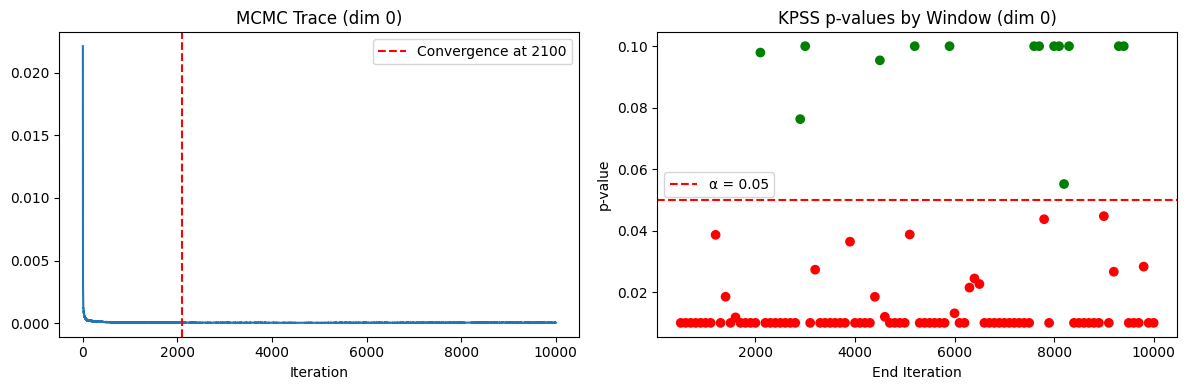

Run 4: Sigmas convergence_iter = 2100
All runs convergence_iter: [1700, 1200, 1700, 2100, 2100]


In [25]:
import numpy as np
from diagnosis import segmented_kpss_test

# mtmh
sigmas = experiment_results['mtmh'].item()['sigmas']  # shape: [n_runs, n_chains, n_iter]
n_runs, n_chains, _, _ = sigmas.shape

window_size = 500
step = 100
alpha = 0.05

convergence_iters = []
for run_id in range(n_runs):
    chain_sigmas = sigmas[run_id, 0]
    result = segmented_kpss_test(chain_sigmas, window_size=window_size, step=step, alpha=alpha)
    convergence_iters.append(result['convergence_iteration'])
    print(f"Run {run_id}: Sigmas convergence_iter = {result['convergence_iteration']}")

print("All runs convergence_iter:", convergence_iters)

## Preds

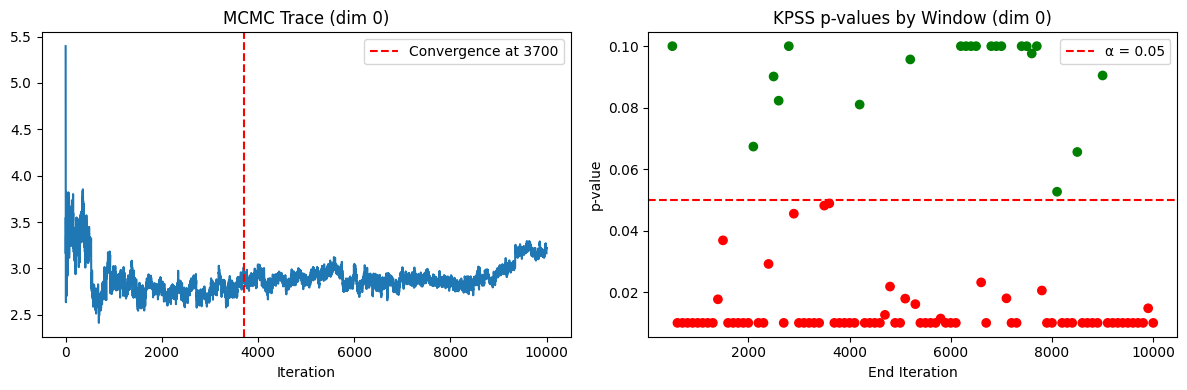

Run 0: convergence_iter = 3700


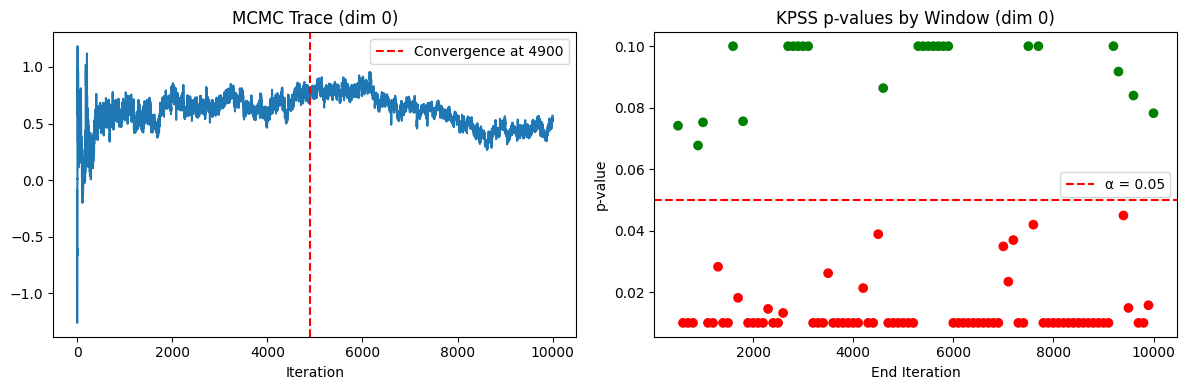

Run 1: convergence_iter = 4900


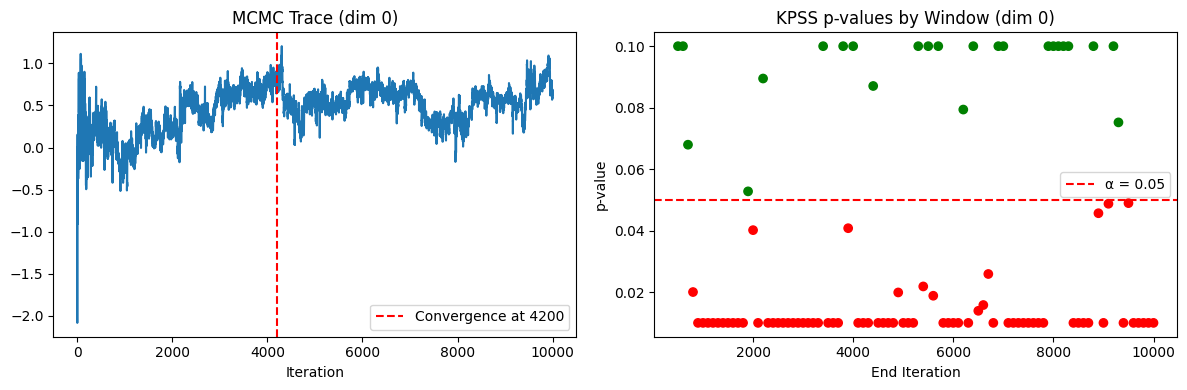

Run 2: convergence_iter = 4200


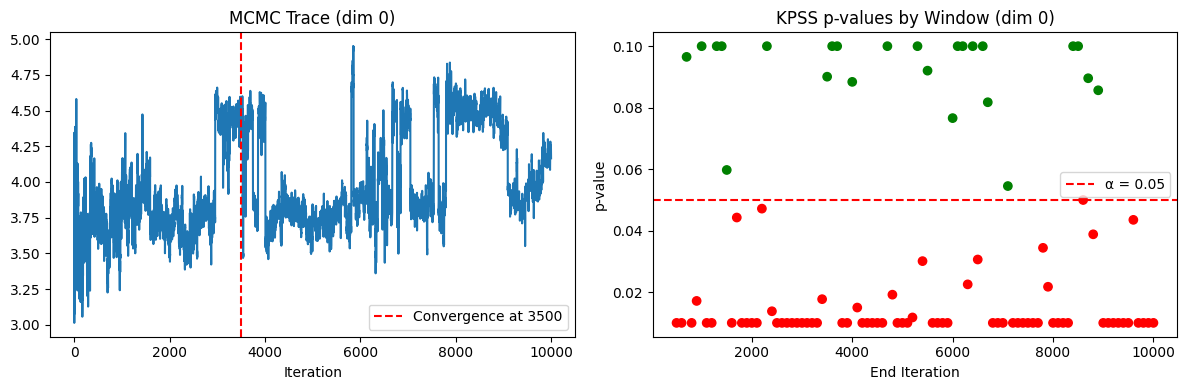

Run 3: convergence_iter = 3500


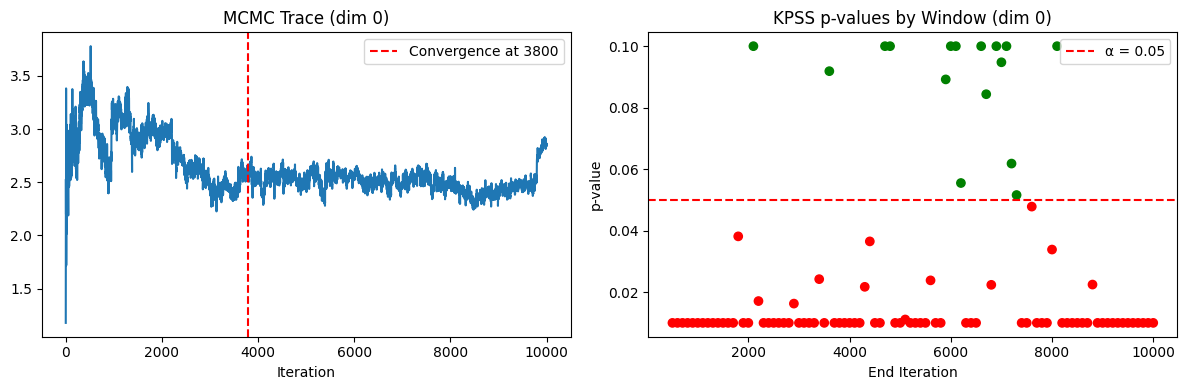

Run 4: convergence_iter = 3800
All runs convergence_iter: [3700, 4900, 4200, 3500, 3800]


In [26]:
import numpy as np
from diagnosis import segmented_kpss_test

# default
preds = experiment_results['default'].item()['preds']  # shape: [n_runs, n_chains, n_test_points, n_iter]
n_runs, n_chains, n_test_points, n_iter = preds.shape

window_size = 500
step = 100
alpha = 0.05

convergence_iters = []
for run_id in range(n_runs):
    # shape: [n_test_points, n_iter]
    chain_preds = preds[run_id, 0].T  # [n_iter, n_test_points]
    result = segmented_kpss_test(chain_preds, window_size=window_size, step=step, alpha=alpha)
    convergence_iters.append(result['convergence_iteration'])
    print(f"Run {run_id}: convergence_iter = {result['convergence_iteration']}")

print("All runs convergence_iter:", convergence_iters)

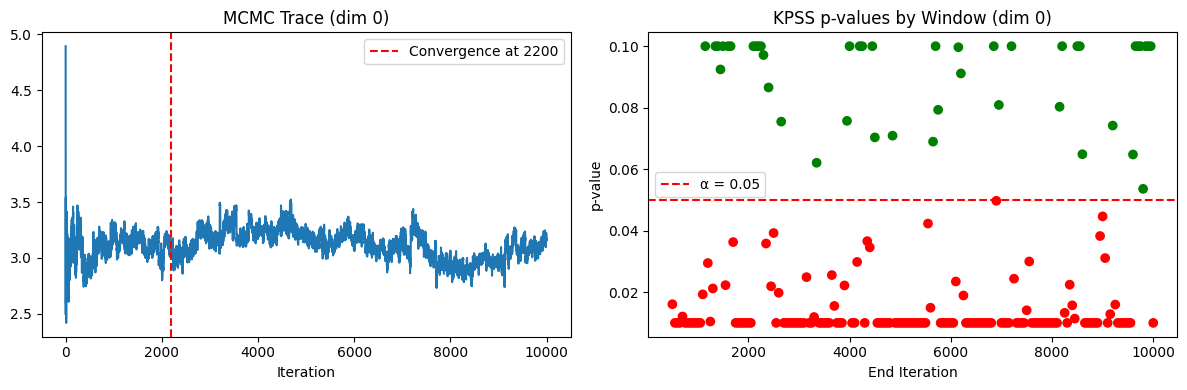

Run 0: convergence_iter = 2200


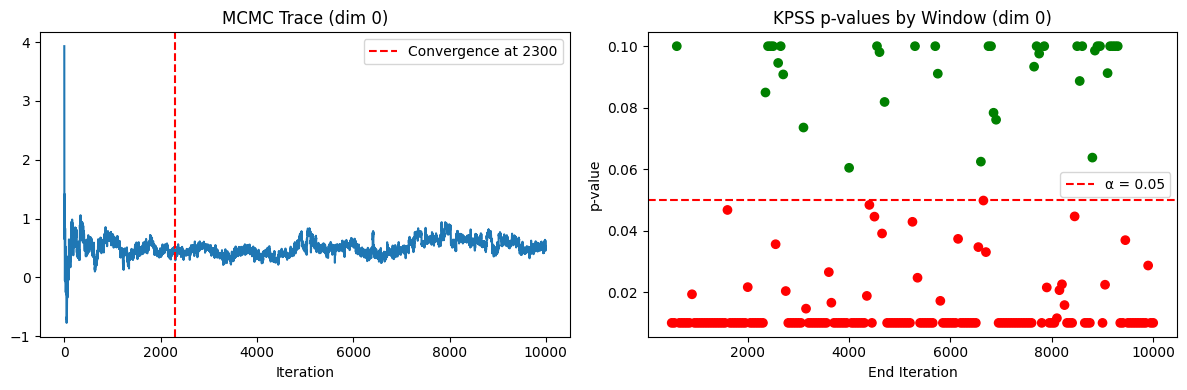

Run 1: convergence_iter = 2300


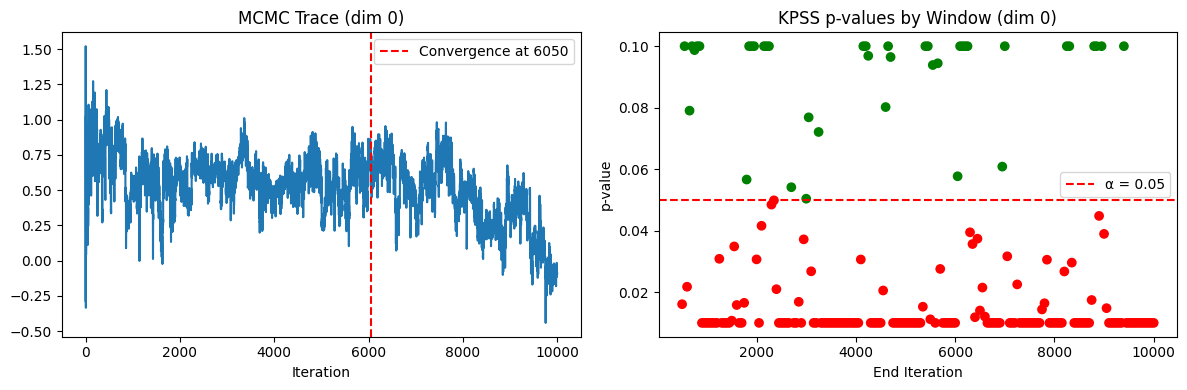

Run 2: convergence_iter = 6050


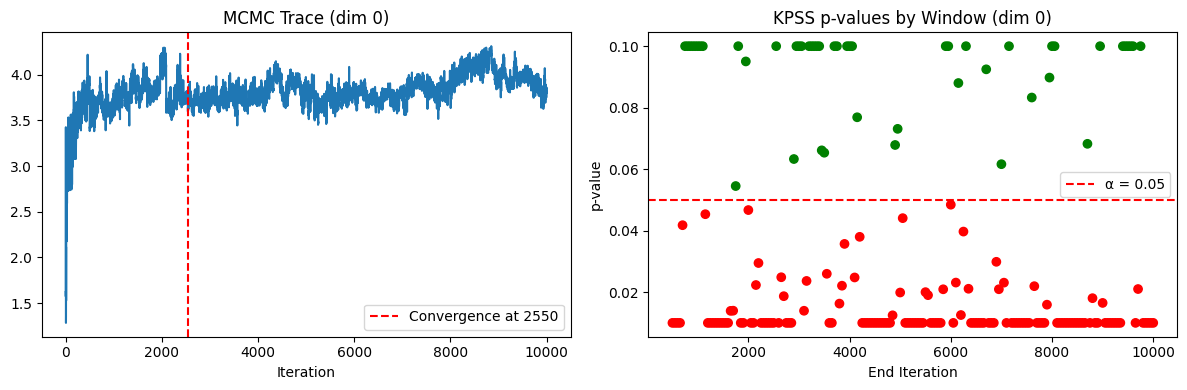

Run 3: convergence_iter = 2550


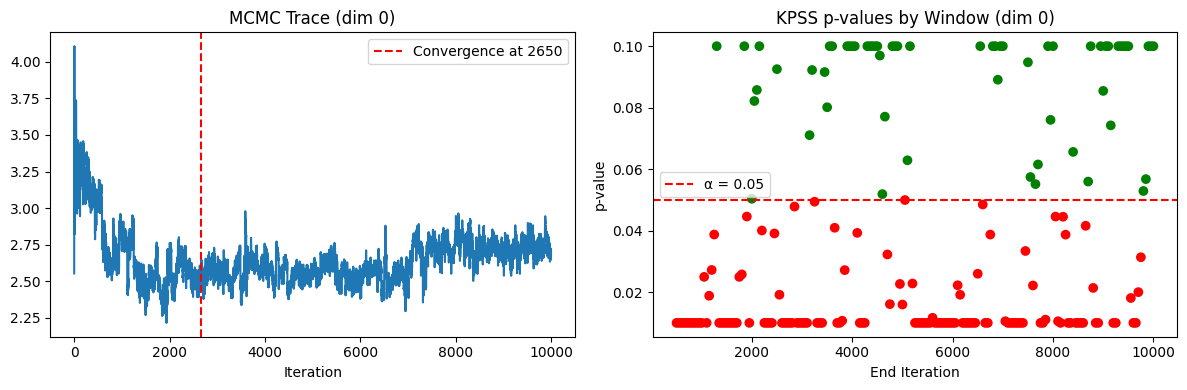

Run 4: convergence_iter = 2650
All runs convergence_iter: [2200, 2300, 6050, 2550, 2650]


In [27]:
import numpy as np
from diagnosis import segmented_kpss_test

# mtmh
preds = experiment_results['mtmh'].item()['preds']  # shape: [n_runs, n_chains, n_test_points, n_iter]
n_runs, n_chains, n_test_points, n_iter = preds.shape

window_size = 500
step = 50
alpha = 0.05

convergence_iters = []
for run_id in range(n_runs):
    # shape: [n_test_points, n_iter]
    chain_preds = preds[run_id, 0].T  # [n_iter, n_test_points]
    result = segmented_kpss_test(chain_preds, window_size=window_size, step=step, alpha=alpha)
    convergence_iters.append(result['convergence_iteration'])
    print(f"Run {run_id}: convergence_iter = {result['convergence_iteration']}")

print("All runs convergence_iter:", convergence_iters)

## Preds (PCA)

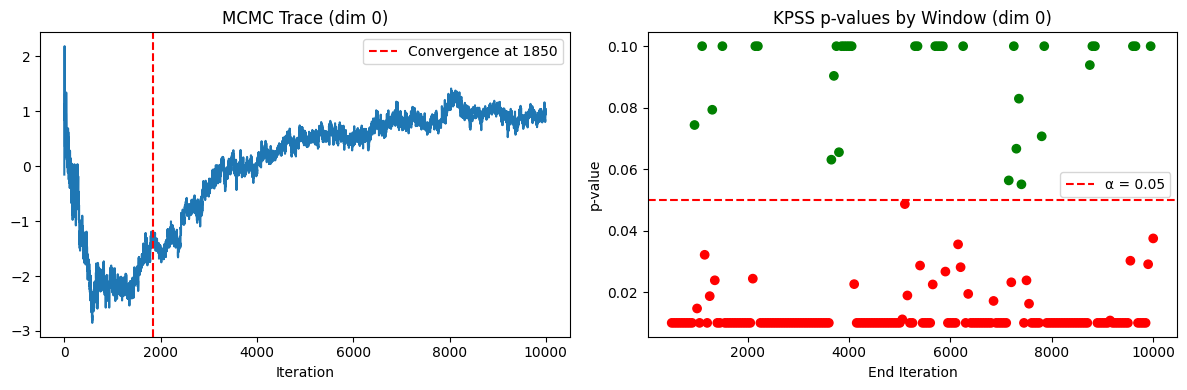

Run 0: convergence_iter = 1850


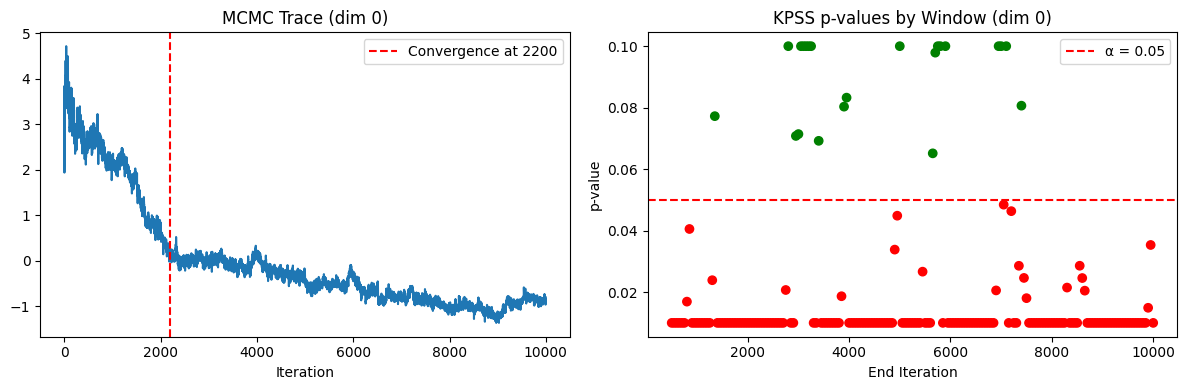

Run 1: convergence_iter = 2200


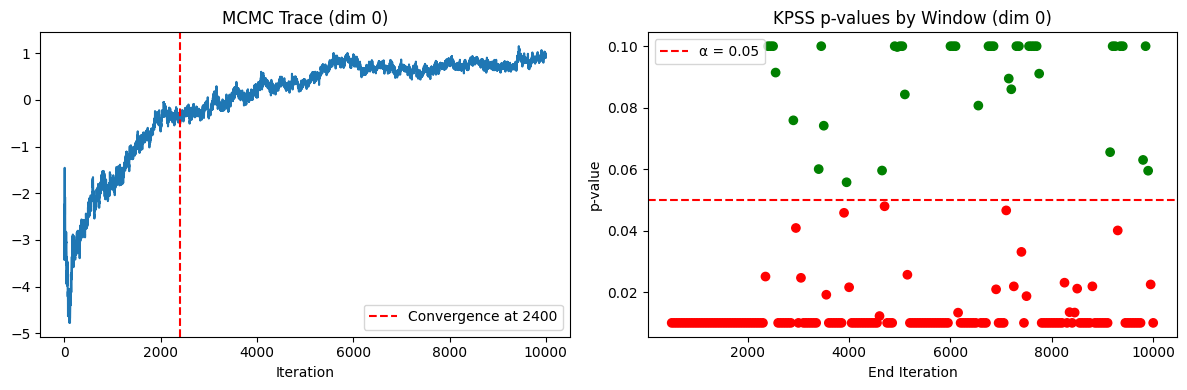

Run 2: convergence_iter = 2400


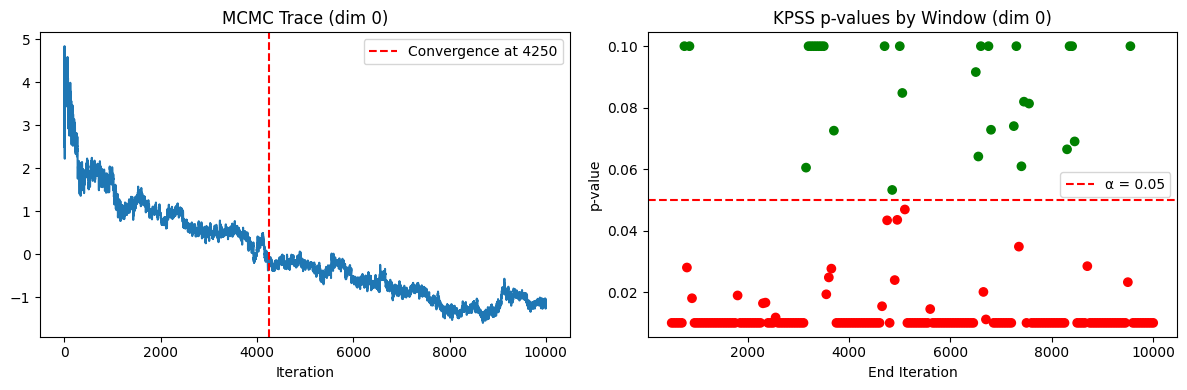

Run 3: convergence_iter = 4250


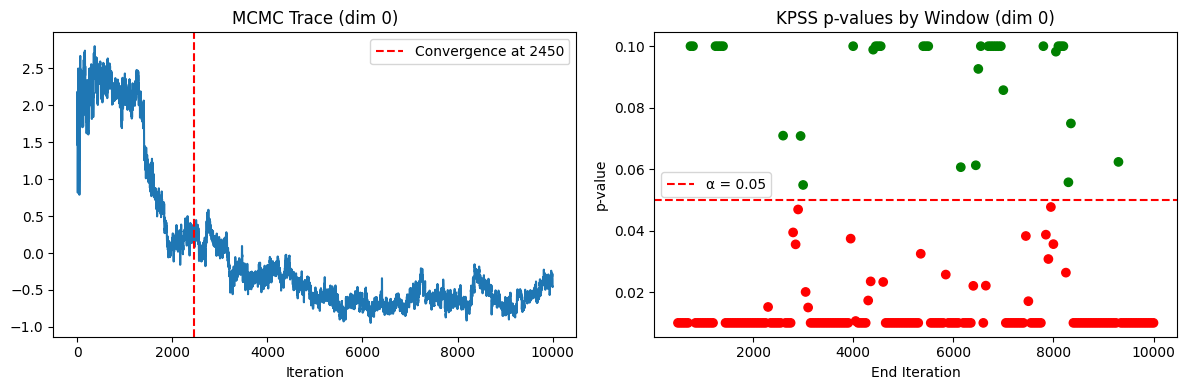

Run 4: convergence_iter = 2450
All runs convergence_iter: [1850, 2200, 2400, 4250, 2450]


In [28]:
import numpy as np
from diagnosis import segmented_kpss_test
from sklearn.decomposition import PCA

# default
preds = experiment_results['default'].item()['preds']  # shape: [n_runs, n_chains, n_test_points, n_iter]
n_runs, n_chains, n_test_points, n_iter = preds.shape

window_size = 500
step = 50
alpha = 0.05

convergence_iters = []
for run_id in range(n_runs):
    # shape: [n_test_points, n_iter]
    chain_preds = preds[run_id, 0].T  # [n_iter, n_test_points]
    chain_preds_centered = chain_preds - np.mean(chain_preds, axis=0)
    pca = PCA(n_components=5)
    chain_preds_pca = pca.fit_transform(chain_preds_centered)
    result = segmented_kpss_test(chain_preds_pca, window_size=window_size, step=step, alpha=alpha)
    convergence_iters.append(result['convergence_iteration'])
    print(f"Run {run_id}: convergence_iter = {result['convergence_iteration']}")

print("All runs convergence_iter:", convergence_iters)

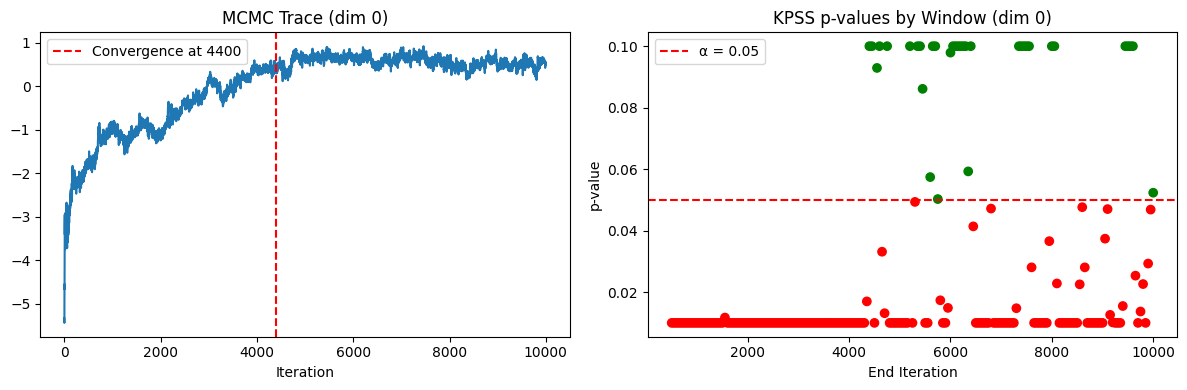

Run 0: convergence_iter = 4400


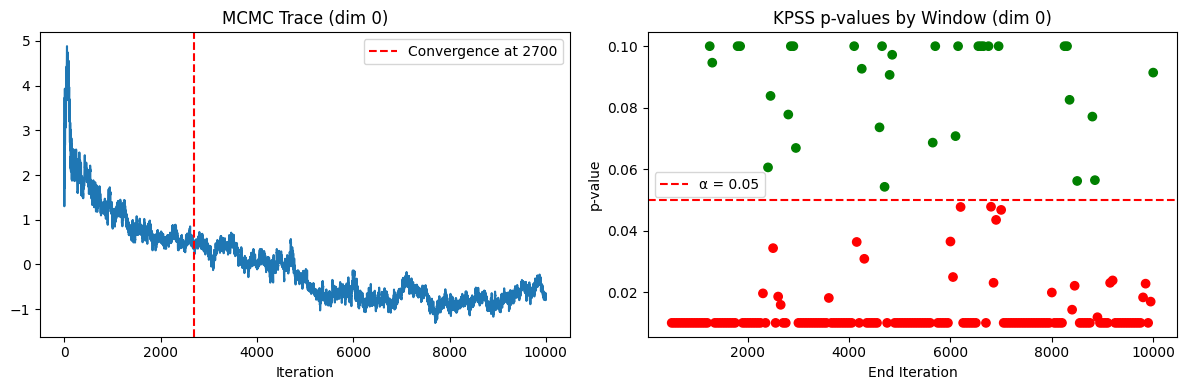

Run 1: convergence_iter = 2700


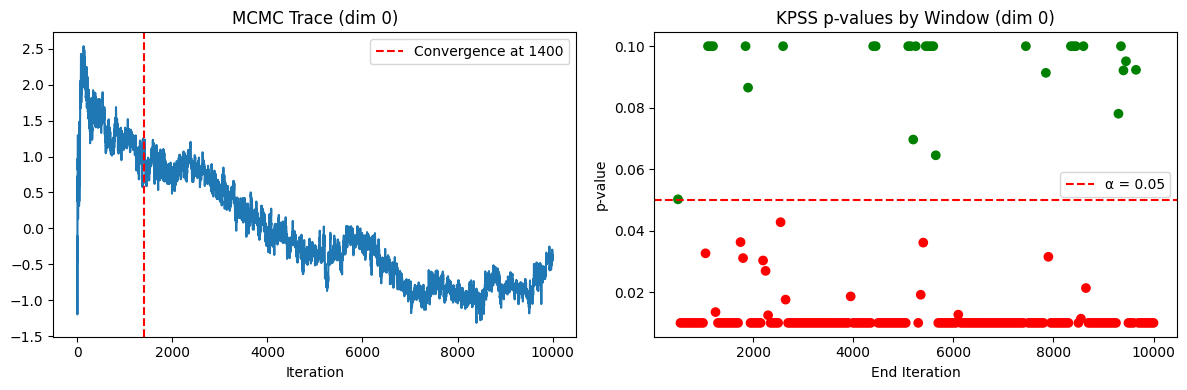

Run 2: convergence_iter = 1400


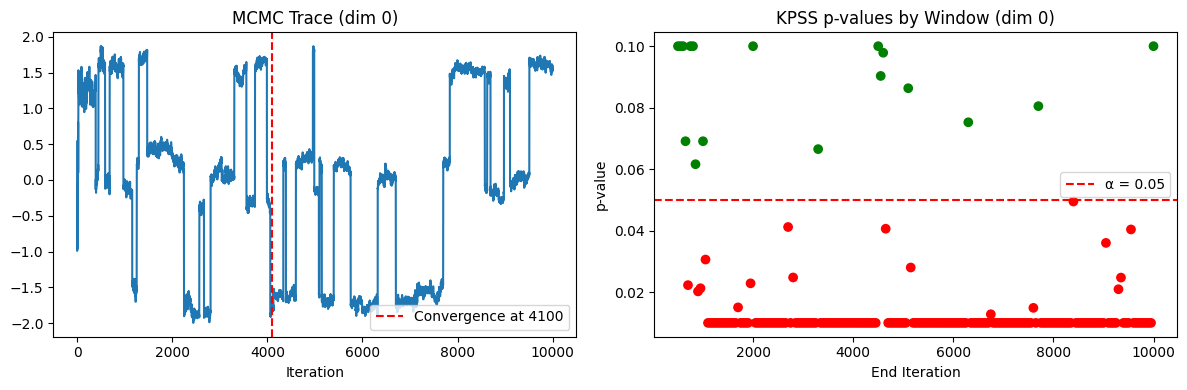

Run 3: convergence_iter = 4100


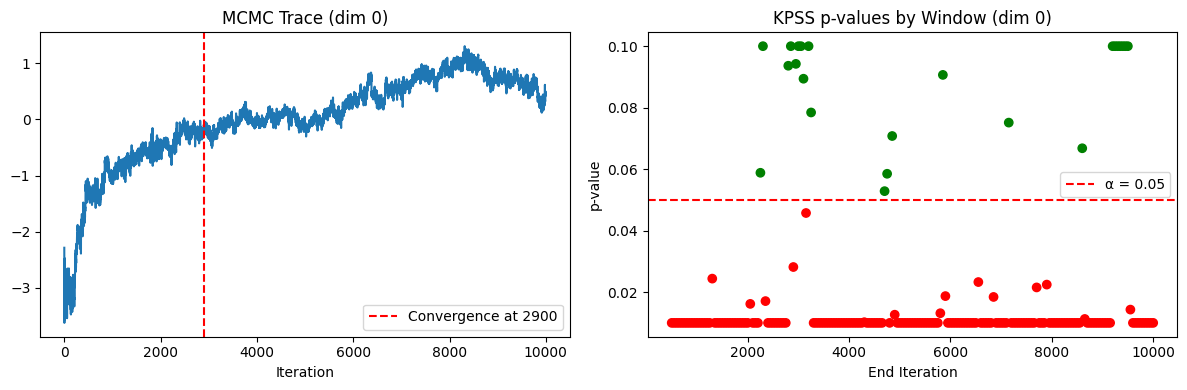

Run 4: convergence_iter = 2900
All runs convergence_iter: [4400, 2700, 1400, 4100, 2900]


In [29]:
import numpy as np
from diagnosis import segmented_kpss_test
from sklearn.decomposition import PCA

# mtmh
preds = experiment_results['mtmh'].item()['preds']  # shape: [n_runs, n_chains, n_test_points, n_iter]
n_runs, n_chains, n_test_points, n_iter = preds.shape

window_size = 500
step = 50
alpha = 0.05

convergence_iters = []
for run_id in range(n_runs):
    # shape: [n_test_points, n_iter]
    chain_preds = preds[run_id, 0].T  # [n_iter, n_test_points]
    chain_preds_centered = chain_preds - np.mean(chain_preds, axis=0)
    pca = PCA(n_components=5)
    chain_preds_pca = pca.fit_transform(chain_preds_centered)
    result = segmented_kpss_test(chain_preds_pca, window_size=window_size, step=step, alpha=alpha)
    convergence_iters.append(result['convergence_iteration'])
    print(f"Run {run_id}: convergence_iter = {result['convergence_iteration']}")

print("All runs convergence_iter:", convergence_iters)

# Rhat (preds)

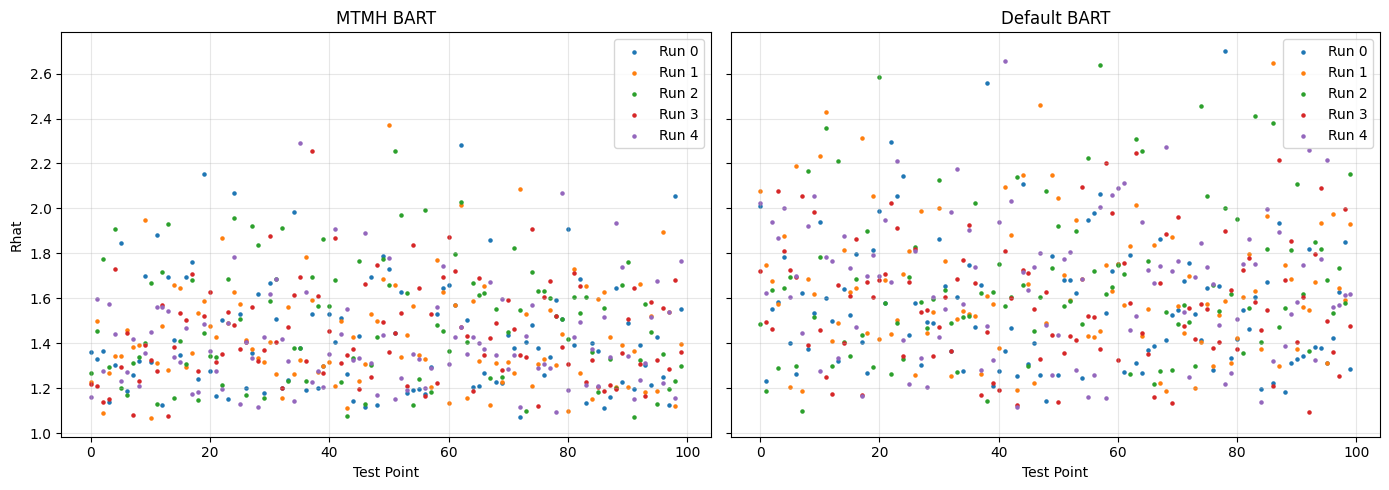

In [30]:
import numpy as np
import arviz as az
import matplotlib.pyplot as plt

def compute_rhat_per_test_point(preds):
    n_runs, n_chains, n_test_points, n_iter = preds.shape
    rhat_all = []
    for run_id in range(n_runs):
        run_rhat = []
        for pt in range(n_test_points):
            # preds: [n_chains, n_iter] for each test point
            x = preds[run_id, :, pt, 3000:]
            rhat_val = az.rhat(x)
            run_rhat.append(rhat_val)
        rhat_all.append(run_rhat)
    return np.array(rhat_all)  # [n_runs, n_test_points]

# Compute Rhat for default and mtmh
preds_default = experiment_results['default'].item()['preds']
preds_mtmh = experiment_results['mtmh'].item()['preds']

rhat_default = compute_rhat_per_test_point(preds_default)
rhat_mtmh = compute_rhat_per_test_point(preds_mtmh)
n_runs, n_test_points = rhat_default.shape

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Left: MTMH
for run_id in range(n_runs):
    axes[0].scatter(np.arange(n_test_points), rhat_mtmh[run_id], label=f'Run {run_id}', s=5)
axes[0].set_xlabel('Test Point')
axes[0].set_ylabel('Rhat')
axes[0].set_title('MTMH BART')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Right: Default
for run_id in range(n_runs):
    axes[1].scatter(np.arange(n_test_points), rhat_default[run_id], label=f'Run {run_id}', s=5)
axes[1].set_xlabel('Test Point')
axes[1].set_title('Default BART')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

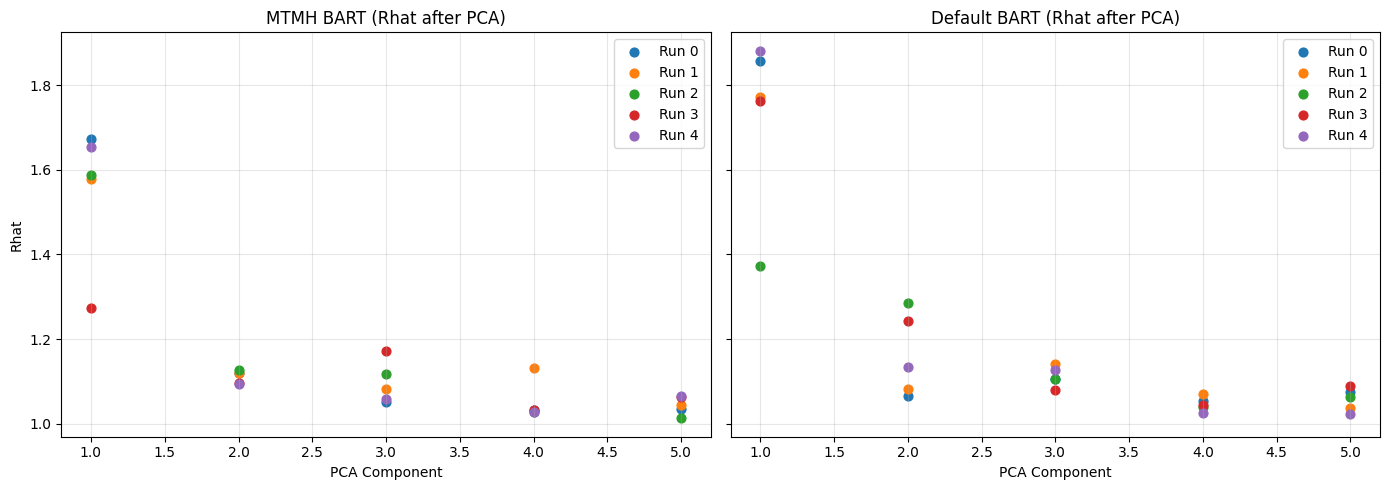

In [31]:
import numpy as np
import arviz as az
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def compute_rhat_pca_per_run(preds, n_components=5):
    n_runs, n_chains, n_test_points, n_iter = preds.shape
    rhat_all = []
    for run_id in range(n_runs):
        # [n_chains, n_test_points, n_iter] -> [n_chains, n_iter, n_test_points]
        x = preds[run_id, :, :, 3000:]
        x = np.transpose(x, (0, 2, 1))
        # Do PCA for each chain
        pca = PCA(n_components=n_components)
        z = np.array([pca.fit_transform(x_chain) for x_chain in x])  # [n_chains, n_iter, n_components]
        rhat_run = []
        for k in range(n_components):
            # z[:, :, k]: [n_chains, n_iter] for component k
            rhat_val = az.rhat(z[:, :, k])
            rhat_run.append(rhat_val)
        rhat_all.append(rhat_run)
    return np.array(rhat_all)  # [n_runs, n_components]

# Compute Rhat after PCA for default and mtmh
preds_default = experiment_results['default'].item()['preds']
preds_mtmh = experiment_results['mtmh'].item()['preds']

rhat_default_pca = compute_rhat_pca_per_run(preds_default)
rhat_mtmh_pca = compute_rhat_pca_per_run(preds_mtmh)
n_runs, n_components = rhat_default_pca.shape

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Left: MTMH
for run_id in range(n_runs):
    axes[0].scatter(np.arange(1, n_components+1), rhat_mtmh_pca[run_id], label=f'Run {run_id}', s=40)
axes[0].set_xlabel('PCA Component')
axes[0].set_ylabel('Rhat')
axes[0].set_title('MTMH BART (Rhat after PCA)')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Right: Default
for run_id in range(n_runs):
    axes[1].scatter(np.arange(1, n_components+1), rhat_default_pca[run_id], label=f'Run {run_id}', s=40)
axes[1].set_xlabel('PCA Component')
axes[1].set_title('Default BART (Rhat after PCA)')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# ESS (preds)

In [32]:
import numpy as np
from arviz.stats import ess
import matplotlib.pyplot as plt

def compute_ess_per_test_point(preds):
    n_runs, n_chains, n_test_points, n_iter = preds.shape
    ess_all = []
    for run_id in range(n_runs):
        run_ess = []
        for pt in range(n_test_points):
            # [n_chains, n_iter]
            x = preds[run_id, :, pt, 3000:]
            ess_val = ess(x, relative=True)
            run_ess.append(ess_val)
        ess_all.append(run_ess)
    return np.array(ess_all)  # [n_runs, n_test_points]

# Compute ESS for default and mtmh
preds_default = experiment_results['default'].item()['preds']
preds_mtmh = experiment_results['mtmh'].item()['preds']

ess_default = compute_ess_per_test_point(preds_default)
ess_mtmh = compute_ess_per_test_point(preds_mtmh)
n_runs, n_test_points = ess_default.shape

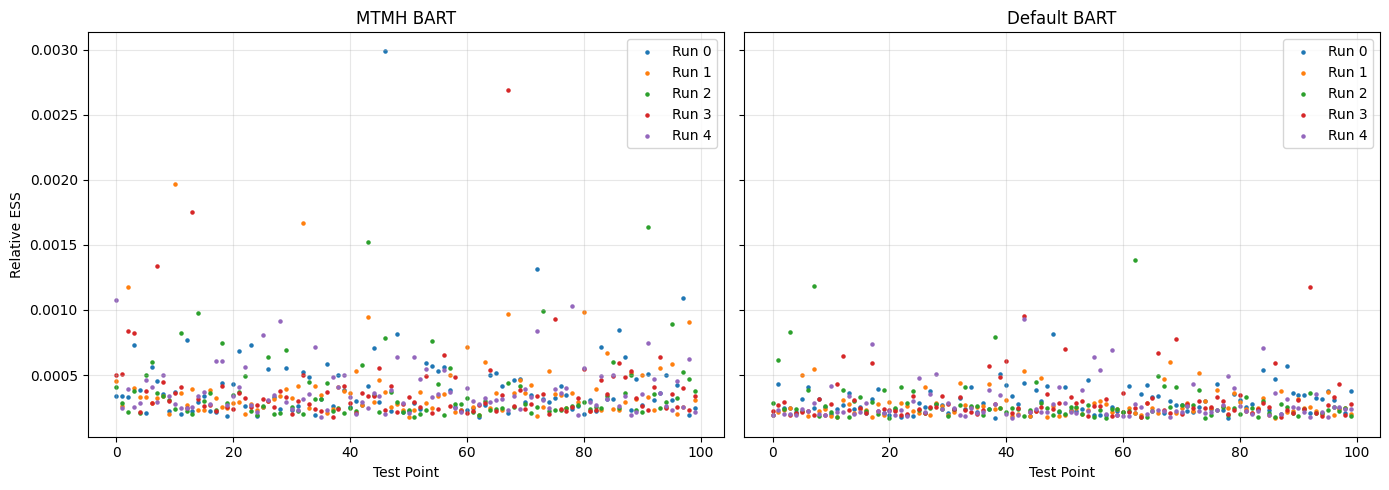

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Left: MTMH
for run_id in range(n_runs):
    axes[0].scatter(np.arange(n_test_points), ess_mtmh[run_id], label=f'Run {run_id}', s=5)
axes[0].set_xlabel('Test Point')
axes[0].set_ylabel('Relative ESS')
axes[0].set_title('MTMH BART')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Right: Default
for run_id in range(n_runs):
    axes[1].scatter(np.arange(n_test_points), ess_default[run_id], label=f'Run {run_id}', s=5)
axes[1].set_xlabel('Test Point')
axes[1].set_title('Default BART')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

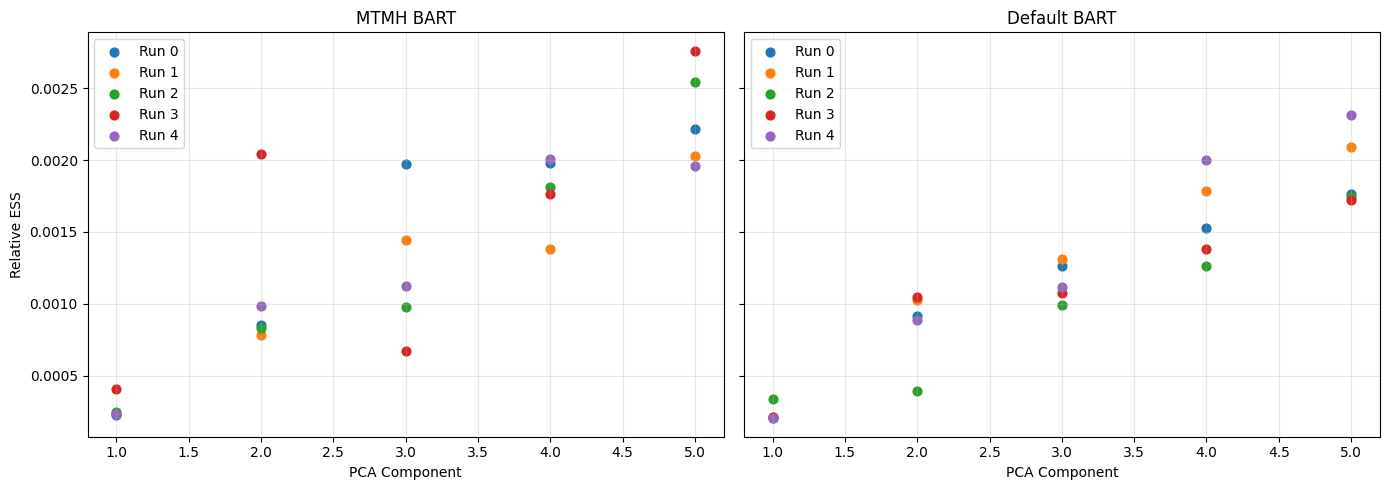

In [34]:
import numpy as np
from arviz.stats import ess
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def compute_ess_per_run(preds):
    n_runs, n_chains, n_test_points, n_iter = preds.shape
    ess_all = []
    for run_id in range(n_runs):
        x = preds[run_id, :, :, 3000:]  # [n_chains, n_test_points, n_iter]
        x = np.transpose(x, (0, 2, 1))  # [n_chains, n_iter, n_test_points]
        pca = PCA(n_components=5)
        z = np.array([pca.fit_transform(x_chain) for x_chain in x])  # [n_chains, n_iter, 5]
        ess_run = []
        for k in range(z.shape[2]):
            ess_val = ess(z[:, :, k], relative=True)
            ess_run.append(ess_val)
        ess_all.append(ess_run)
    return np.array(ess_all)  # [n_runs, 5]

# Compute ESS for default and mtmh
preds_default = experiment_results['default'].item()['preds']
preds_mtmh = experiment_results['mtmh'].item()['preds']

ess_default = compute_ess_per_run(preds_default)
ess_mtmh = compute_ess_per_run(preds_mtmh)

n_runs, n_components = ess_default.shape

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Left: MTMH
for run_id in range(n_runs):
    axes[0].scatter(np.arange(1, n_components+1), ess_mtmh[run_id], label=f'Run {run_id}', s=40)
axes[0].set_xlabel('PCA Component')
axes[0].set_ylabel('Relative ESS')
axes[0].set_title('MTMH BART')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Right: Default
for run_id in range(n_runs):
    axes[1].scatter(np.arange(1, n_components+1), ess_default[run_id], label=f'Run {run_id}', s=40)
axes[1].set_xlabel('PCA Component')
axes[1].set_title('Default BART')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Autocorrelation Plot (preds)

=== Default BART Analysis ===

--- Run 0 ---
Default PCA first component autocorrelation plot:


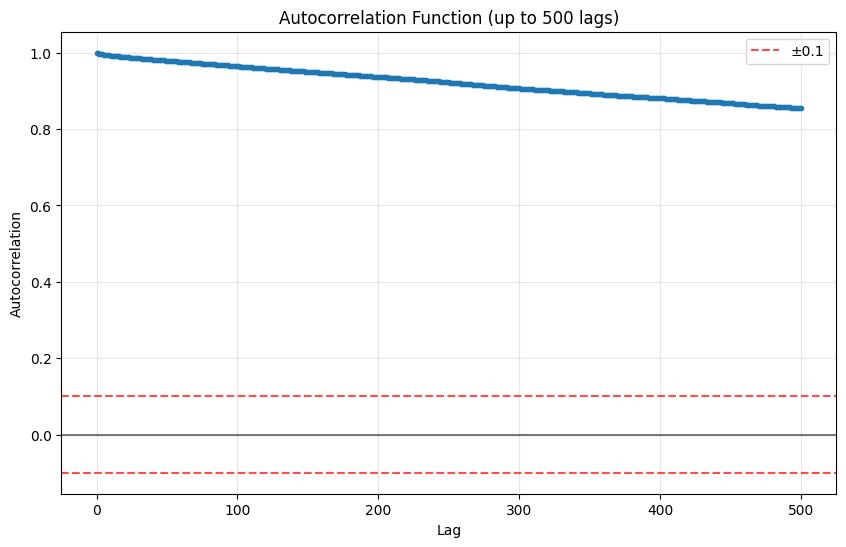


--- Run 1 ---
Default PCA first component autocorrelation plot:


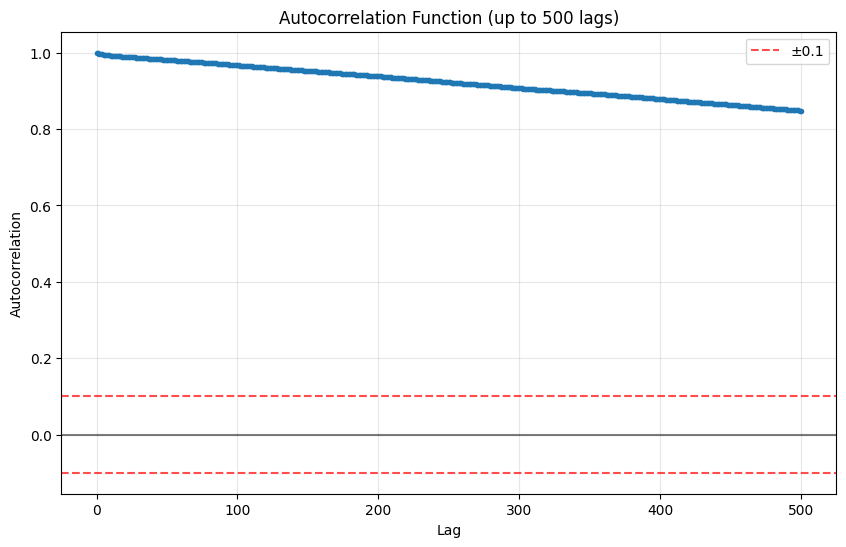


--- Run 2 ---
Default PCA first component autocorrelation plot:


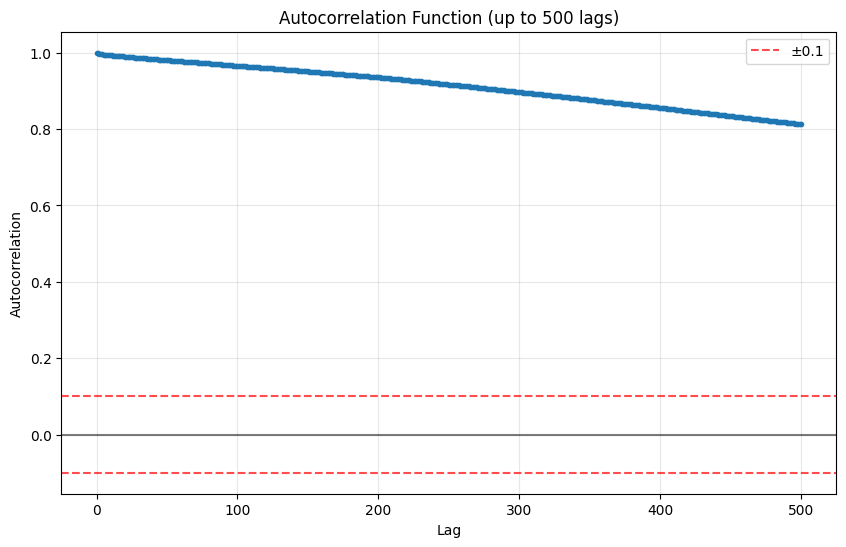


--- Run 3 ---
Default PCA first component autocorrelation plot:


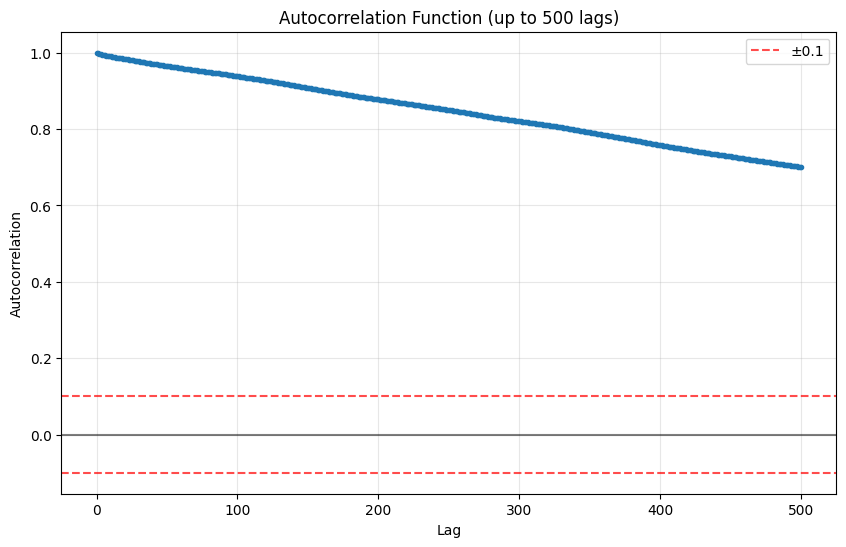


--- Run 4 ---
Default PCA first component autocorrelation plot:


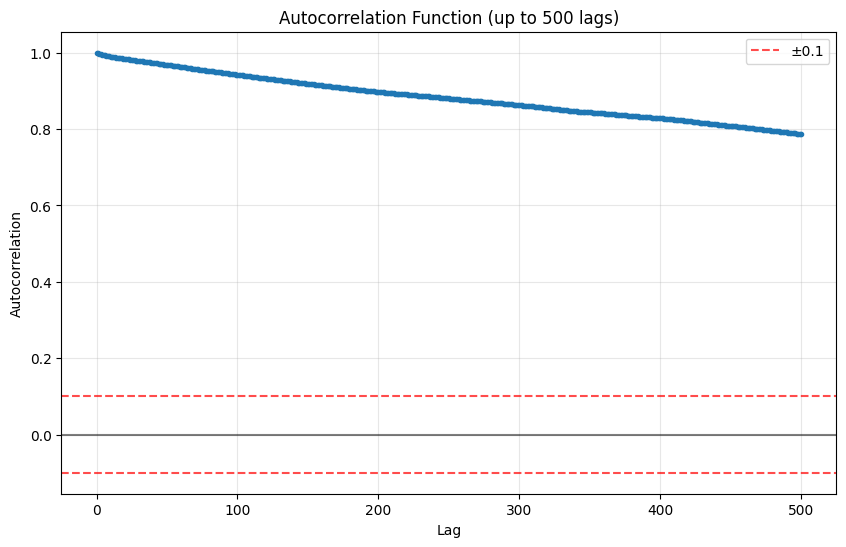

In [35]:
from diagnosis import plot_autocorrelation
from sklearn.decomposition import PCA
# Analyze each run's results
n_runs = 5

# Analyze Default BART results
print("=== Default BART Analysis ===")
for run_id in range(n_runs):
    print(f"\n--- Run {run_id} ---")
    
    # Extract data for this run
    preds = experiment_results['default'].item()['preds'][run_id, 0, :, 3000:]  # [n_test_points, n_iter]
    pred0 = preds[0, :]  # First test point
    x = np.transpose(preds, (1, 0))  # [n_iter, n_test_points]
    pca = PCA(n_components=5)
    z = pca.fit_transform(x)  # [n_iter, n_components]
    pca0 = z[:, 0]  # First PCA component

    # print(f"Default first pred autocorrelation plot:")
    # plot_autocorrelation(pred0, nlags=500)

    print(f"Default PCA first component autocorrelation plot:")
    plot_autocorrelation(pca0, nlags=500)

=== MTMH BART Analysis ===

--- Run 0 ---
MTMH PCA first component autocorrelation plot:


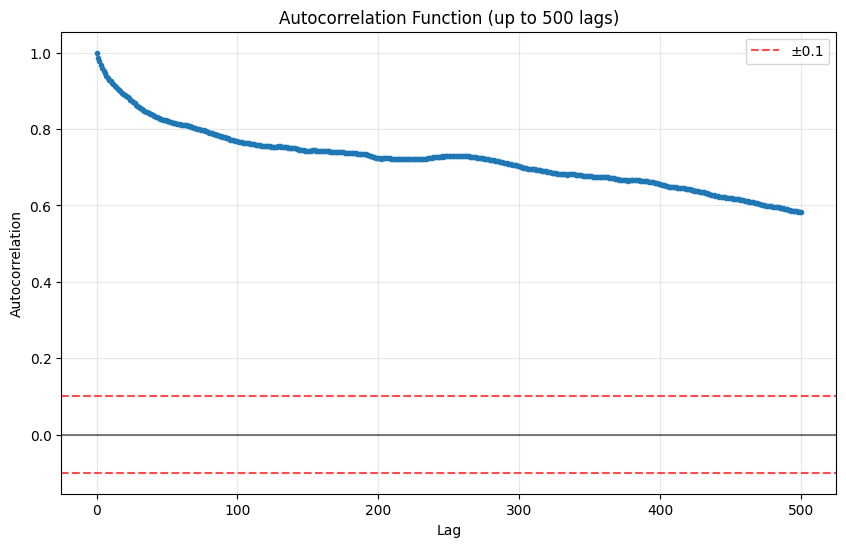


--- Run 1 ---
MTMH PCA first component autocorrelation plot:


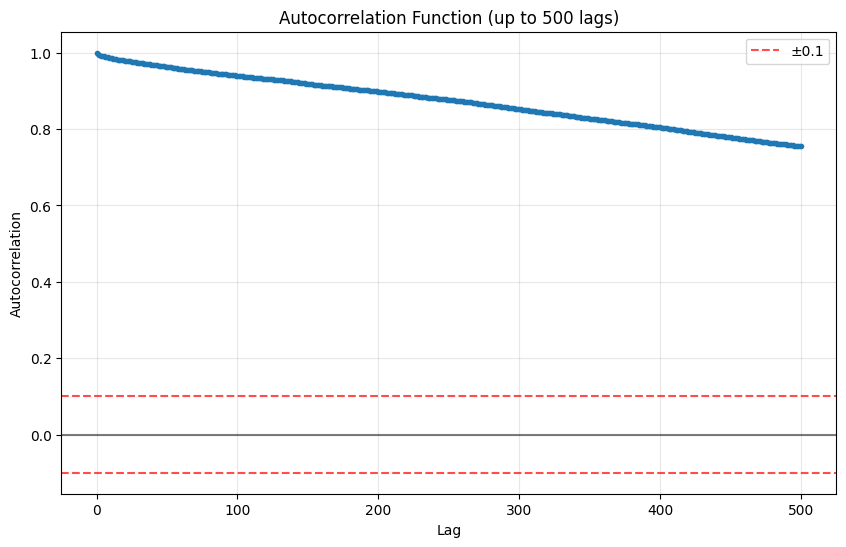


--- Run 2 ---
MTMH PCA first component autocorrelation plot:


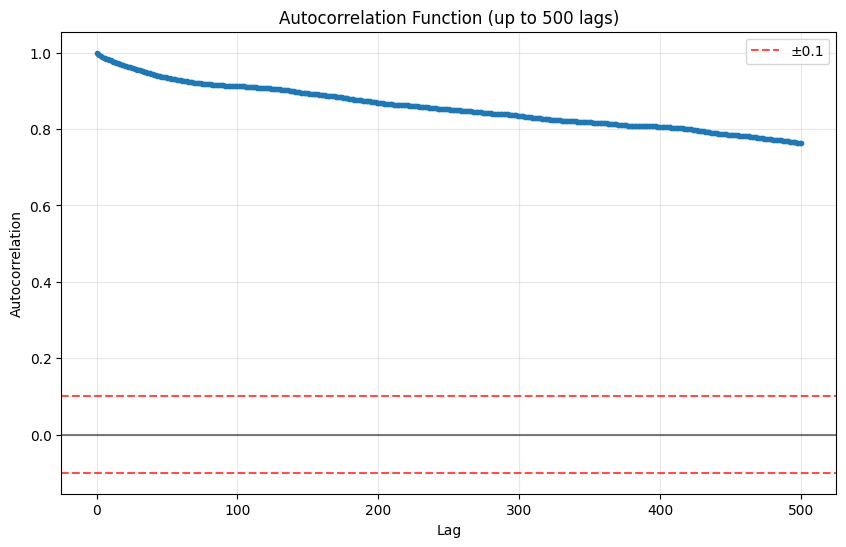


--- Run 3 ---
MTMH PCA first component autocorrelation plot:


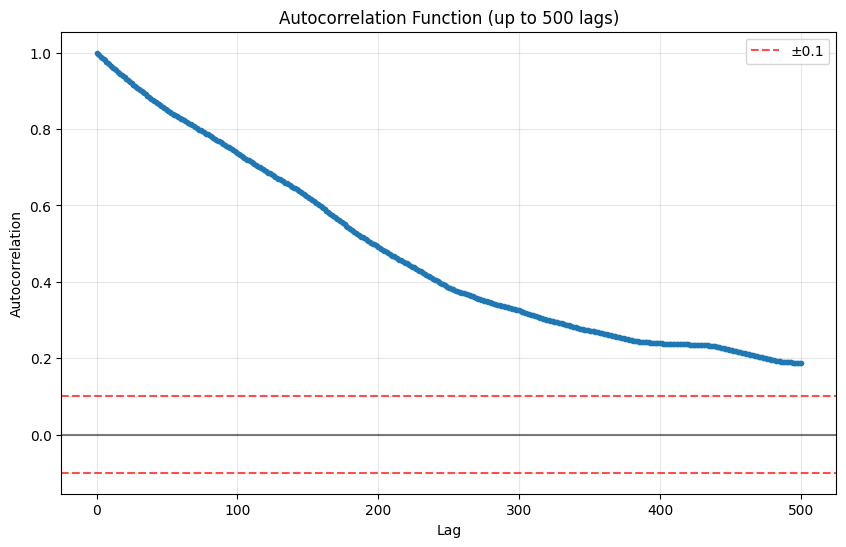


--- Run 4 ---
MTMH PCA first component autocorrelation plot:


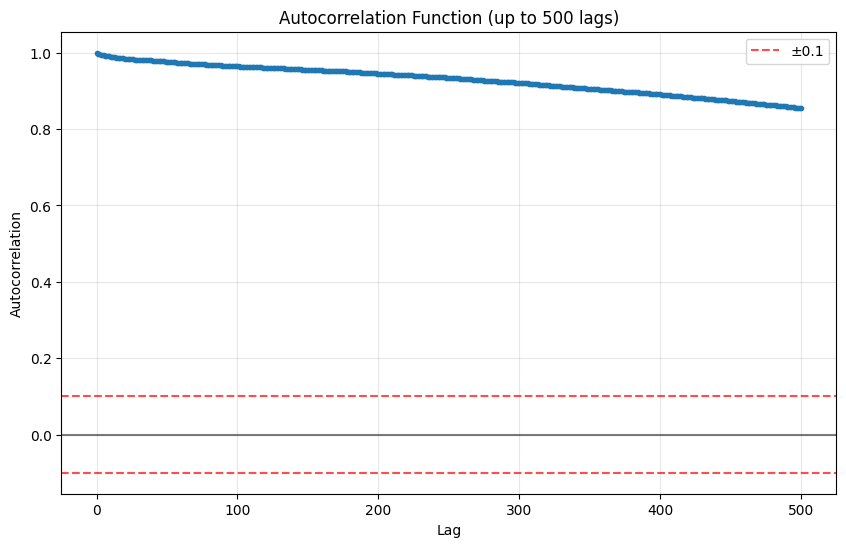

In [36]:
from diagnosis import plot_autocorrelation
from sklearn.decomposition import PCA
# Analyze each run's results
n_runs = 5

# Analyze MTMH BART results
print("=== MTMH BART Analysis ===")
for run_id in range(n_runs):
    print(f"\n--- Run {run_id} ---")
    
    # Extract data for this run
    preds = experiment_results['mtmh'].item()['preds'][run_id, 0, :, 3000:]  # [n_test_points, n_iter]
    pred0 = preds[0, :]  # First test point
    x = np.transpose(preds, (1, 0))  # [n_iter, n_test_points]
    pca = PCA(n_components=5)
    z = pca.fit_transform(x)  # [n_iter, n_components]
    pca0 = z[:, 0]  # First PCA component

    # print(f"MTMH first pred autocorrelation plot:")
    # plot_autocorrelation(pred0, nlags=500)

    print(f"MTMH PCA first component autocorrelation plot:")
    plot_autocorrelation(pca0, nlags=500)

# Vector distance comparison (within chain / between chains)

In [ ]:
from diagnosis import compute_within_and_between_chain_distances

default_preds = experiment_results['default'].item()['preds']  # [n_runs, n_chains, n_test_points, n_iter]
n_runs = default_preds.shape[0]

within_list = []
between_list = []
for run_id in range(n_runs):
    preds = default_preds[run_id][:, :, 3000:]  # [n_chains, n_test_points, n_iter]
    mean_within, mean_between = compute_within_and_between_chain_distances(preds, max_pairs=1000, random_state=42)
    within_list.append(mean_within)
    between_list.append(mean_between)
    print(f"Run {run_id}: mean within-chain distance = {mean_within:.4f}, mean between-chain distance = {mean_between:.4f}")

print("All runs mean within-chain distance:", np.mean(within_list))
print("All runs mean between-chain distance:", np.mean(between_list))
print("Ratio between-chain / within-chain:", np.mean(np.array(between_list) / np.array(within_list)))

Run 0: mean within-chain distance = 1.9312, mean between-chain distance = 3.1197
Run 1: mean within-chain distance = 1.9167, mean between-chain distance = 3.2972
Run 2: mean within-chain distance = 1.9755, mean between-chain distance = 3.2711
Run 3: mean within-chain distance = 1.8817, mean between-chain distance = 2.8578
Run 4: mean within-chain distance = 1.8334, mean between-chain distance = 2.9603
All runs mean within-chain distance: 1.9077094969836874
All runs mean between-chain distance: 3.1012134715418838
Ratio between-chain / within-chain: 1.62496539336006


In [ ]:
from diagnosis import compute_within_and_between_chain_distances

default_preds = experiment_results['mtmh'].item()['preds']  # [n_runs, n_chains, n_test_points, n_iter]
n_runs = default_preds.shape[0]

within_list = []
between_list = []
for run_id in range(n_runs):
    preds = default_preds[run_id][:, :, 3000:]  # [n_chains, n_test_points, n_iter]
    mean_within, mean_between = compute_within_and_between_chain_distances(preds, max_pairs=1000, random_state=42)
    within_list.append(mean_within)
    between_list.append(mean_between)
    print(f"Run {run_id}: mean within-chain distance = {mean_within:.4f}, mean between-chain distance = {mean_between:.4f}")

print("All runs mean within-chain distance:", np.mean(within_list))
print("All runs mean between-chain distance:", np.mean(between_list))
print("Ratio between-chain / within-chain:", np.mean(np.array(between_list) / np.array(within_list)))

Run 0: mean within-chain distance = 1.9686, mean between-chain distance = 3.0916
Run 1: mean within-chain distance = 2.1639, mean between-chain distance = 2.9421
Run 2: mean within-chain distance = 1.9907, mean between-chain distance = 2.9672
Run 3: mean within-chain distance = 2.1770, mean between-chain distance = 2.9262
Run 4: mean within-chain distance = 2.0125, mean between-chain distance = 2.6273
All runs mean within-chain distance: 2.062531951658324
All runs mean between-chain distance: 2.91088923324974
Ratio between-chain / within-chain: 1.414060727402444
